Processing 200 files from ambulance...
Processing 200 files from firetruck...
Processing 200 files from traffic...

✅ Dataset loaded and RAW MFE features extracted (P3).
   Total samples (incl. augmentation): 1000
   Feature tensor shape: (1000, 98, 43)  (N, n_frames, n_mels)
   Total feature extraction time: 5.167 s
   Avg feature extraction time per sample: 0.005167 s
   Class distribution: {np.str_('ambulance'): 400, np.str_('firetruck'): 400, np.str_('traffic'): 200}

================ P3 RAW MFE 1D-CNN: 5-Fold CV ================

🔍 FOLD 1/5
   Train samples: 640
   Val samples:   160
   Test samples:  200
Epoch 1/100
5/5 - 2s - 318ms/step - accuracy: 0.3125 - loss: 1.2479 - val_accuracy: 0.3688 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 2/100
5/5 - 0s - 21ms/step - accuracy: 0.4187 - loss: 1.1002 - val_accuracy: 0.4125 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 3/100
5/5 - 0s - 18ms/step - accuracy: 0.5453 - loss: 0.9645 - val_accuracy: 0.4938 - val_loss: 1.0442 - lear

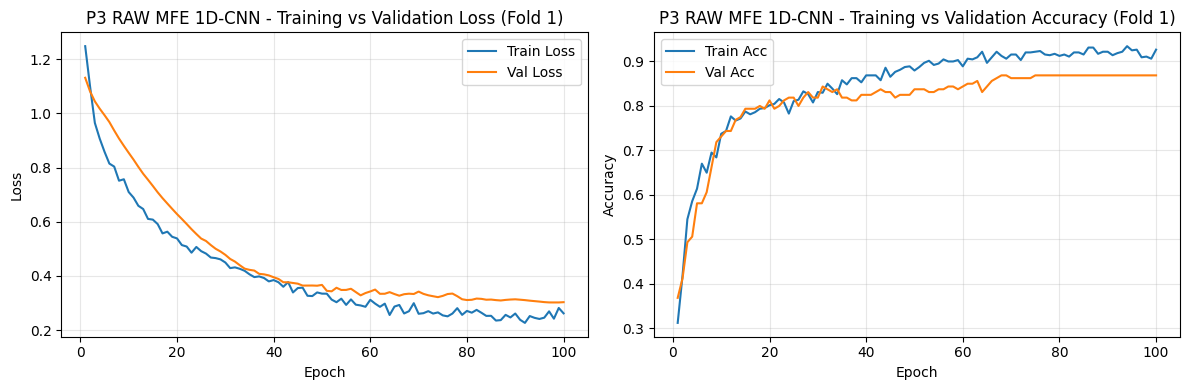

In [3]:
import os
import time
import random

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: make GPU memory growth safe
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


class Timer:
    """Simple wall-clock timer."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


# =========================
# RAW MFE feature extractor
# =========================

class RawMFEExtractor:
    """
    Ekstraktor RAW Mel-Filterbank Energy untuk P3:

    - Sample rate: 44.1 kHz
    - Durasi: 1 detik
    - Frame length: 25 ms
    - Frame stride: 10 ms
    - n_fft: 2048
    - n_mels: 43

    Output: tensor (n_frames, n_mels) ~ (98, 43) berisi log-MFE yang
    sudah dinormalisasi secara kasar ke [0, 1].
    """

    def __init__(
        self,
        target_sr=44100,
        duration=1.0,
        frame_length=0.025,
        frame_stride=0.01,
        n_mels=43,
        n_fft=2048,
        snr_db=15.0,
    ):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_length = frame_length
        self.frame_stride = frame_stride
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.snr_db = snr_db

        self.target_len = int(self.target_sr * self.duration)
        self.hop_length = int(round(self.frame_stride * self.target_sr))
        self.win_length = int(round(self.frame_length * self.target_sr))

        # jumlah frame waktu (harusnya ~98)
        self.n_frames = 1 + (self.target_len - self.win_length) // self.hop_length

    def _preprocess(self, y, sr):
        # resample
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # fix duration (pad atau cut)
        if len(y) < self.target_len:
            y = np.pad(y, (0, self.target_len - len(y)), mode="constant")
        else:
            y = y[: self.target_len]

        # normalisasi amplitude ke [-1, 1]
        y = librosa.util.normalize(y)
        return y, self.target_sr

    def _augment_white_noise(self, y):
        """Augmentasi white noise SNR tertentu (opsional untuk kelas tertentu)."""
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))
        noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        y_noisy = y + noise
        y_noisy = librosa.util.normalize(y_noisy)
        return y_noisy

    def _mfe_tensor(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self._preprocess(y, sr)

        if apply_augmentation:
            y_proc = self._augment_white_noise(y_proc)

        # Mel-spectrogram -> log-MFE
        mel = librosa.feature.melspectrogram(
            y=y_proc,
            sr=sr_proc,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            fmin=80.0,
            fmax=sr_proc / 2.0,
            power=2.0,
            htk=False,
            norm="slaney",
        )  # (n_mels, T)

        log_mel = np.log(mel + 1e-8)  # raw MFE (log-energi)

        # pastikan jumlah frame = self.n_frames
        n_bands, T = log_mel.shape
        if T > self.n_frames:
            # ambil frame pertama self.n_frames
            log_mel = log_mel[:, : self.n_frames]
        elif T < self.n_frames:
            # pad dengan nilai minimum tiap band
            pad_width = self.n_frames - T
            pad_vals = np.min(log_mel, axis=1, keepdims=True)
            pad = np.repeat(pad_vals, pad_width, axis=1)
            log_mel = np.concatenate([log_mel, pad], axis=1)

        # transpose jadi (time, mel)
        feat = log_mel.T  # (n_frames, n_mels)

        # normalisasi kasar ke [0, 1] dengan asumsi rentang [-80, 0] dB
        min_db = -80.0
        max_db = 0.0
        feat_norm = (feat - min_db) / (max_db - min_db)
        feat_norm = np.clip(feat_norm, 0.0, 1.0)

        return feat_norm.astype(np.float32)

    def extract_from_file(self, filepath, label=None, augment_for_labels=None):
        """Return list of tensors: [original, (optional) augmented]."""
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = [self._mfe_tensor(y, sr, apply_augmentation=False)]

        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self._mfe_tensor(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader (RAW MFE)
# =========================

class AudioDatasetRawMFE:
    """
    Struktur folder:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav

    Hasil: X (N, n_frames, n_mels) dan y (label string),
    dengan augmentasi optional untuk kelas tertentu.
    """

    def __init__(
        self,
        base_dir,
        mfe_extractor,
        class_names=None,
        augment=True,
        augment_for=("ambulance", "firetruck"),
        max_files_per_class=None,
    ):
        self.base_dir = base_dir
        self.mfe = mfe_extractor
        self.augment = augment
        self.augment_for = set(augment_for)
        self.class_names = (
            class_names if class_names is not None else ["ambulance", "firetruck", "traffic"]
        )
        self.max_files_per_class = max_files_per_class

    def load(self):
        X_list = []
        y_list = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue

            files = [
                f
                for f in sorted(os.listdir(class_dir))
                if f.lower().endswith((".wav", ".flac", ".ogg", ".mp3", ".m4a"))
            ]

            if self.max_files_per_class is not None:
                files = files[: self.max_files_per_class]

            print(f"Processing {len(files)} files from {label}...")

            for fname in files:
                fpath = os.path.join(class_dir, fname)
                feats = self.mfe.extract_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None,
                )
                for feat in feats:
                    X_list.append(feat)
                    y_list.append(label)

        X = np.stack(X_list, axis=0)  # (N, n_frames, n_mels)
        y = np.array(y_list)
        return X, y


# =========================
# P3 model: RAW MFE 1D-CNN
# =========================

from tensorflow.keras import regularizers

def build_p3_model(input_shape, num_classes,
                   dropout_rate=0.40,
                   l2_lambda=5e-4,
                   lr=0.5e-4):
    """
    P3: RAW MFE 1D-CNN (versi stabil & ringan)
    - Conv1D(8) → BN → MaxPool → Dropout
    - Conv1D(16) → BN → MaxPool → Dropout
    - GlobalAveragePooling1D
    - Dense(16) → Dropout
    - Dense(num_classes)
    """
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Block 2
    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Global pooling (lebih sedikit parameter daripada Flatten)
    x = layers.GlobalAveragePooling1D()(x)

    # Bottleneck kecil
    x = layers.Dense(
        16,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="P3_RAW_MFE_1D_CNN")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# =========================
# Experiment runner (P3)
# =========================

def run_p3_experiment(
    data_dir,
    n_splits=5,
    epochs=100,
    batch_size=128,
    max_files_per_class=None,
):
    # 1. Ekstraksi fitur (RAW MFE)
    mfe_extractor = RawMFEExtractor()
    dataset = AudioDatasetRawMFE(
        data_dir,
        mfe_extractor,
        max_files_per_class=max_files_per_class,
    )

    feat_timer = Timer()
    feat_timer.start()
    X_raw, y_labels = dataset.load()
    feat_timer.stop()

    n_samples = X_raw.shape[0]
    n_frames, n_mels = X_raw.shape[1], X_raw.shape[2]
    feat_time_total = feat_timer.get_elapsed()
    feat_time_per_sample = feat_time_total / max(n_samples, 1)

    class_counts = {c: int(np.sum(y_labels == c)) for c in np.unique(y_labels)}

    print("\n✅ Dataset loaded and RAW MFE features extracted (P3).")
    print(f"   Total samples (incl. augmentation): {n_samples}")
    print(f"   Feature tensor shape: {X_raw.shape}  (N, n_frames, n_mels)")
    print(f"   Total feature extraction time: {feat_time_total:.3f} s")
    print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
    print(f"   Class distribution: {class_counts}")

    # 2. Encode label
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)
    num_classes = len(label_encoder.classes_)

    # 3. K-Fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    acc_list = []
    f1_list = []
    prec_list = []
    rec_list = []
    infer_time_per_sample_list = []

    histories = []

    fold_idx = 1
    input_shape = (n_frames, n_mels)
    D = n_frames * n_mels

    print("\n================ P3 RAW MFE 1D-CNN: {}-Fold CV ================".format(n_splits))

    for train_index, test_index in skf.split(X_raw, y):
        print("\n" + "=" * 60)
        print(f"🔍 FOLD {fold_idx}/{n_splits}")
        print("=" * 60)

        X_train_full, X_test = X_raw[train_index], X_raw[test_index]
        y_train_full, y_test = y[train_index], y[test_index]

        # ---- Scaling: flatten -> StandardScaler -> reshape ----
        scaler = StandardScaler()

        X_train_flat = X_train_full.reshape(X_train_full.shape[0], D)
        X_test_flat = X_test.reshape(X_test.shape[0], D)

        X_train_scaled_flat = scaler.fit_transform(X_train_flat)
        X_test_scaled_flat = scaler.transform(X_test_flat)

        X_train_scaled = X_train_scaled_flat.reshape(-1, *input_shape)
        X_test_scaled = X_test_scaled_flat.reshape(-1, *input_shape)

        # ---- Split train menjadi train/val (internal) ----
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled,
            y_train_full,
            test_size=0.2,
            stratify=y_train_full,
            random_state=SEED,
        )

        print(f"   Train samples: {X_train.shape[0]}")
        print(f"   Val samples:   {X_val.shape[0]}")
        print(f"   Test samples:  {X_test_scaled.shape[0]}")

        # ---- Build & train model ----
        model = build_p3_model(input_shape=input_shape, num_classes=num_classes, dropout_rate=0.40, l2_lambda=5e-4, lr=5e-4)

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1,
        )
        reduce_lr = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1,
        )

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=2,
            callbacks=[early_stop, reduce_lr],
        )
        histories.append(history)

        # ---- Evaluate on test fold ----
        infer_timer = Timer()
        infer_timer.start()
        y_proba = model.predict(X_test_scaled, batch_size=batch_size, verbose=0)
        infer_timer.stop()

        infer_time_per_sample = infer_timer.get_elapsed() / len(X_test_scaled)
        y_pred = np.argmax(y_proba, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")

        acc_list.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
        infer_time_per_sample_list.append(infer_time_per_sample)

        print(f"   Fold {fold_idx} accuracy: {acc:.4f}")
        print(f"   Fold {fold_idx} F1-macro: {f1:.4f}")
        print(f"   Fold {fold_idx} precision: {prec:.4f}, recall: {rec:.4f}")
        print(f"   Inference time per sample (test): {infer_time_per_sample:.6f} s")

        fold_idx += 1

    # 4. Ringkasan
    summary_rows = []

    def mean_std_str(vals):
        return f"{np.mean(vals):.4f} ± {np.std(vals):.4f}"

    summary_rows.append(
        {
            "Model": "P3 RAW MFE 1D-CNN",
            "Accuracy (mean±std)": mean_std_str(acc_list),
            "F1 Score (mean±std)": mean_std_str(f1_list),
            "Precision (mean±std)": mean_std_str(prec_list),
            "Recall (mean±std)": mean_std_str(rec_list),
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{np.mean(infer_time_per_sample_list):.6f}",
        }
    )

    results_df = pd.DataFrame(summary_rows)
    results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

    print("\n" + "=" * 80)
    print("HASIL {}-FOLD CROSS VALIDATION (P3: RAW MFE 1D-CNN)".format(n_splits))
    print("=" * 80)
    print(results_df.to_string(index=False))

    return results_df, histories


# =========================
# Plot training history
# =========================

def plot_training_history(histories, fold_to_plot=0, title_prefix="P3"):
    """
    Plot kurva training vs validation loss & accuracy
    untuk salah satu fold (default: fold pertama).
    """
    if not histories:
        print("No histories to plot.")
        return
    if fold_to_plot < 0 or fold_to_plot >= len(histories):
        print("Invalid fold index.")
        return

    history = histories[fold_to_plot]
    epochs = range(1, len(history.history["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    plt.plot(epochs, history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Training vs Validation Loss (Fold {fold_to_plot+1})")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], label="Train Acc")
    plt.plot(epochs, history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Training vs Validation Accuracy (Fold {fold_to_plot+1})")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# =========================
# Main
# =========================

if __name__ == "__main__":
    # Sesuaikan path dataset
    data_dir = "./sounds"

    # max_files_per_class bisa None atau integer (misal 100) kalau mau batasi
    results_p3, histories_p3 = run_p3_experiment(
        data_dir=data_dir,
        n_splits=5,
        epochs=100,
        batch_size=128,
        max_files_per_class=None,
    )

    # Tampilkan grafik training untuk fold pertama
    plot_training_history(histories_p3, fold_to_plot=0, title_prefix="P3 RAW MFE 1D-CNN")

✅ Dataset loaded and Stat-MFE features extracted for CNN.
   Total samples (incl. augmentation): 1000
   Feature dimension: 396
   Total feature extraction time: 18.459 s
   Avg feature extraction time per sample: 0.018459 s
   Extra memory during feature extraction: 3.21 MB

🔍 CNN FOLD 1/5

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.


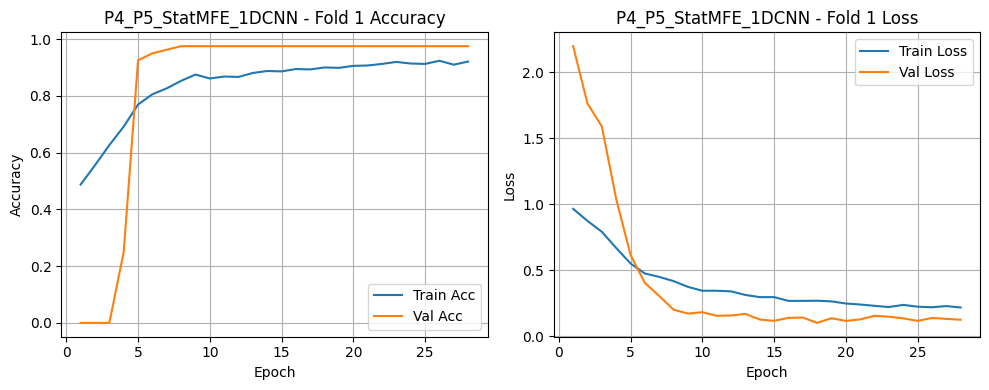

   P4_P5_StatMFE_1DCNN fold accuracy: 0.9100, F1-macro: 0.9188
   P4_P5_StatMFE_1DCNN inference time per sample (test): 0.000686 s
   P4_P5_StatMFE_1DCNN extra memory (train+test): 19.41 MB

🔍 CNN FOLD 2/5

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.


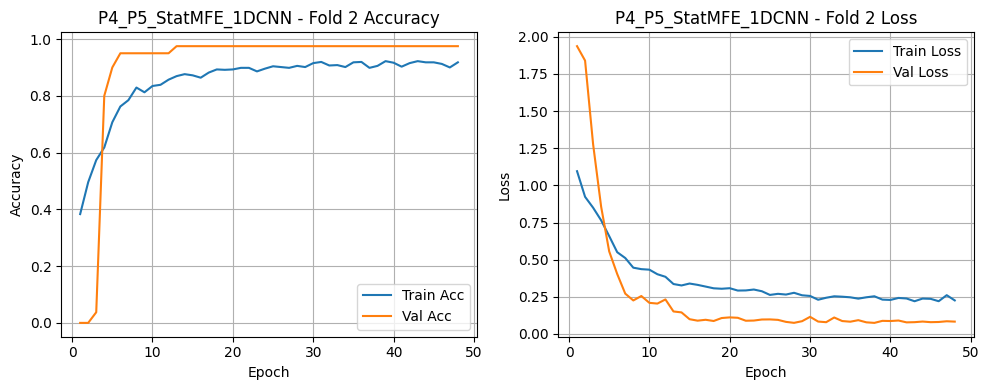

   P4_P5_StatMFE_1DCNN fold accuracy: 0.9450, F1-macro: 0.9520
   P4_P5_StatMFE_1DCNN inference time per sample (test): 0.000694 s
   P4_P5_StatMFE_1DCNN extra memory (train+test): 21.18 MB

🔍 CNN FOLD 3/5

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 25.


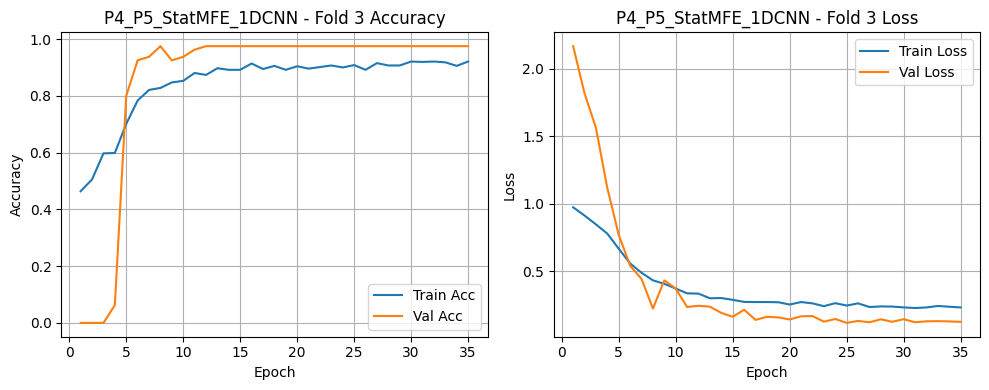

   P4_P5_StatMFE_1DCNN fold accuracy: 0.9050, F1-macro: 0.9167
   P4_P5_StatMFE_1DCNN inference time per sample (test): 0.000785 s
   P4_P5_StatMFE_1DCNN extra memory (train+test): 15.02 MB

🔍 CNN FOLD 4/5

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 40.


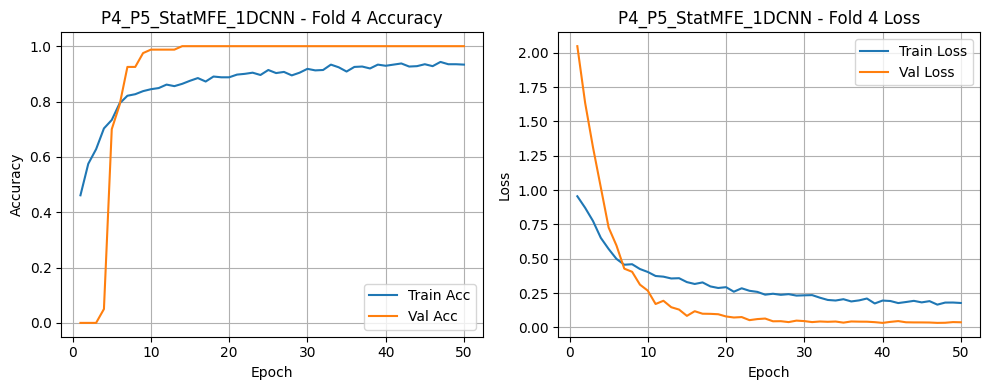

   P4_P5_StatMFE_1DCNN fold accuracy: 0.9350, F1-macro: 0.9458
   P4_P5_StatMFE_1DCNN inference time per sample (test): 0.000732 s
   P4_P5_StatMFE_1DCNN extra memory (train+test): 12.48 MB

🔍 CNN FOLD 5/5

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 31.


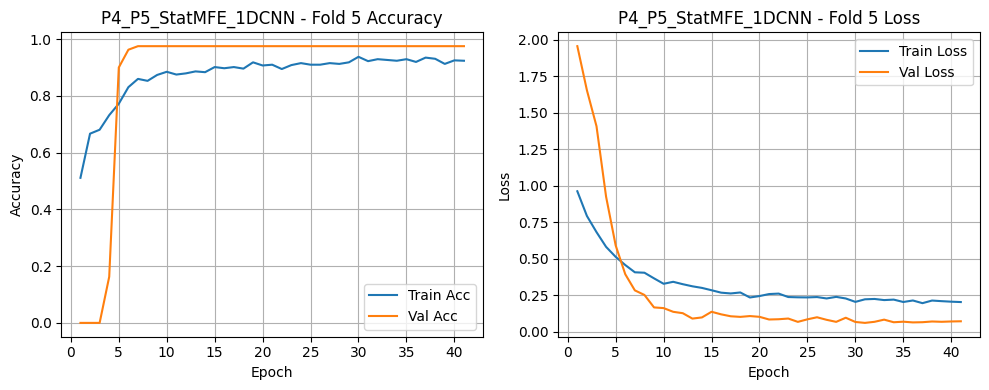

   P4_P5_StatMFE_1DCNN fold accuracy: 0.9350, F1-macro: 0.9458
   P4_P5_StatMFE_1DCNN inference time per sample (test): 0.000789 s
   P4_P5_StatMFE_1DCNN extra memory (train+test): 14.32 MB

HASIL 5-FOLD CROSS VALIDATION (P4_P5_StatMFE_1DCNN)
 No               Model Accuracy (mean±std) F1 Score (mean±std) Run Time Ekstraksi Fitur per Sampel [s] Run Time Inference per Sampel [s] (mean test) Memory usage tambahan [MB] (train+test, mean)
  1 P4_P5_StatMFE_1DCNN     0.9260 ± 0.0156     0.9358 ± 0.0150                                0.018459                                      0.000737                                         16.48


In [ ]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt


from scipy.signal import hilbert
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# === NEW: TensorFlow / Keras untuk CNN P4/P5 ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: amanin GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# =========================
# Utility classes
# =========================

class Timer:
    """Simple timer utility to measure elapsed wall-clock time (in seconds)."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


class MemoryTracker:
    """
    Memory tracking utility (MB).
    Tracks baseline and peak RSS of the current process and
    returns delta (peak - baseline).
    """
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self._get_current_memory()
        self.peak = self.baseline

    def _get_current_memory(self):
        return self.process.memory_info().rss / (1024 * 1024)

    def update(self):
        current = self._get_current_memory()
        if current > self.peak:
            self.peak = current
        return current

    def get_usage(self):
        # Update once more at the end and return peak - baseline
        self.update()
        return self.peak - self.baseline


class FeatureScaler:
    """
    Standardization (zero mean, unit variance)
    + Min-Max normalization to [0, 1].
    Fitted only on training data within each fold.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  # avoid division by zero

        X_std = (X - self.mean_) / self.std_

        self.min_ = X_std.min(axis=0)
        self.max_ = X_std.max(axis=0)
        same = self.max_ == self.min_
        self.max_[same] = self.min_[same] + 1.0  # avoid zero range

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_std = (X - self.mean_) / self.std_
        X_norm = (X_std - self.min_) / (self.max_ - self.min_)
        return X_norm

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# =========================
# Feature extraction
# =========================

class FeatureExtractor:
    """
    Modular feature pipeline (bisa untuk B1, B2, B3/PMFE, dan P4/P5 CNN):

    Grup fitur (bisa di-ON/OFF):
    - Time-domain: mean RMS, mean ZCR
    - Basic spectral: spectral centroid, bandwidth, roll-off
    - Min/Max freq: min & max freq > -40 dB
    - MFCC: 13 mean MFCC
    - MFE (Stat-MFE 396-D): 43 mel band × 9 statistik + 9 fitur global
    - Chroma: 12-dim chroma STFT (mean)
    - Doppler/motion: mean IF, mean chirp rate, mean spectral flux
    """

    def __init__(self,
                 target_sr=41000,
                 duration=3.0,
                 frame_size=1024,
                 hop_length=512,
                 snr_db=15.0,
                 use_time=True,
                 use_basic_spectral=True,
                 use_minmaxfreq=True,
                 use_mfcc=True,
                 use_mfe=False,
                 use_chroma=True,
                 use_doppler=True):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.snr_db = snr_db

        # flags modulasi fitur
        self.use_time = use_time
        self.use_basic_spectral = use_basic_spectral
        self.use_minmaxfreq = use_minmaxfreq
        self.use_mfcc = use_mfcc
        self.use_mfe = use_mfe
        self.use_chroma = use_chroma
        self.use_doppler = use_doppler

    # ---------- Preset helper ----------

    @classmethod
    def from_preset(cls, preset_name, **kwargs):
        """
        Helper untuk bikin FeatureExtractor sesuai preset:
        - "B1" / "all": semua fitur ON (baseline B1: All Features)
        - "mfcc_only": hanya MFCC
        - "spec_no_mfcc": centroid, SBW, roll-off, chroma, min/max freq,
                          + Doppler (IF, chirp, flux) tanpa MFCC, tanpa time.
        - "pmfe": hanya Stat-MFE 396-D (dipakai B3 & P4/P5).
        """
        preset = preset_name.lower()

        base = dict(
            target_sr=41000,
            duration=3.0,
            frame_size=1024,
            hop_length=512,
            snr_db=15.0,
            use_time=True,
            use_basic_spectral=True,
            use_minmaxfreq=True,
            use_mfcc=True,
            use_mfe=False,
            use_chroma=True,
            use_doppler=True,
        )

        if preset in ("b1", "b1_all", "all"):
            # B1: All features (time + all spectral + doppler)
            pass  # pakai base apa adanya
        elif preset in ("b2_mfcc", "mfcc_only"):
            # B2: hanya MFCC (single feature group)
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=True,
                use_chroma=False,
                use_doppler=False,
            ))
        elif preset in ("spec_no_mfcc", "spectral_no_mfcc"):
            # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
            base.update(dict(
                use_time=False,
                use_basic_spectral=True,
                use_minmaxfreq=True,
                use_mfcc=False,
                use_chroma=True,
                use_doppler=True,
            ))
        elif preset in ("pmfe", "mfe_only", "proposed_mfe"):
            # B3/P1/P4/P5: hanya Mel Filterbank Energy (Stat-MFE 396-D) saja
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=False,
                use_mfe=True,
                use_chroma=False,
                use_doppler=False,
            ))
        else:
            raise ValueError(f"Unknown feature preset: {preset_name}")

        # allow override
        base.update(kwargs)
        return cls(**base)

    # ---------- Preprocessing ----------

    def preprocess(self, y, sr):
        # Resample if needed
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # Fixed duration
        target_len = int(self.duration * self.target_sr)
        if len(y) > target_len:
            y = y[:target_len]
        elif len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # Normalize amplitude to [-1, 1]
        max_amp = np.max(np.abs(y)) + 1e-12
        y = y / max_amp
        return y, self.target_sr

    # ---------- Augmentation ----------

    def augment(self, y):
        """
        White noise at target SNR with dynamic factor 0.5–1.5.
        Signal dan noise dinormalisasi sebelum dicampur.
        """
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))

        white_noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        dynamic_factor = np.random.uniform(0.5, 1.5, size=len(y))
        noise = white_noise * dynamic_factor

        sig_max = np.max(np.abs(y)) + 1e-12
        noise_max = np.max(np.abs(noise)) + 1e-12
        y_norm = y / sig_max
        noise_norm = noise / noise_max

        y_aug = y_norm + noise_norm
        y_aug = y_aug / (np.max(np.abs(y_aug)) + 1e-12)
        return y_aug

    # ---------- Time-domain ----------

    def extract_time_domain_features(self, y):
        frames = librosa.util.frame(
            y,
            frame_length=self.frame_size,
            hop_length=self.hop_length
        ).T  # (n_frames, frame_size)

        rms = np.sqrt(np.mean(frames ** 2, axis=1))

        sign_changes = np.diff(np.sign(frames), axis=1) != 0
        zcr = sign_changes.sum(axis=1) / (2.0 * frames.shape[1])

        mean_rms = float(np.mean(rms))
        mean_zcr = float(np.mean(zcr))
        return np.array([mean_rms, mean_zcr], dtype=np.float64)

    # ---------- Spectrogram helper ----------

    def _compute_spectrogram(self, y):
        """
        Compute STFT + derived matrices once, supaya bisa dipakai
        oleh beberapa grup fitur tanpa menghitung ulang.
        """
        stft = librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        )
        P = np.abs(stft) ** 2  # power spectrogram (n_freqs, n_frames)
        freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=self.frame_size)
        S_db = librosa.power_to_db(P, ref=np.max)
        return stft, P, freqs, S_db

    # ---------- Basic spectral: centroid, bandwidth, rolloff ----------

    def extract_basic_spectral_features(self, P, freqs):
        magnitude_sum = P.sum(axis=0) + 1e-12
        centroid = (freqs[:, None] * P).sum(axis=0) / magnitude_sum

        diff = freqs[:, None] - centroid[None, :]
        variance = (diff ** 2 * P).sum(axis=0) / magnitude_sum
        bandwidth = np.sqrt(variance)

        mean_centroid = float(np.mean(centroid))
        mean_bandwidth = float(np.mean(bandwidth))

        rolloff = librosa.feature.spectral_rolloff(
            S=P,
            sr=self.target_sr,
            roll_percent=0.85
        )[0]
        mean_rolloff = float(np.mean(rolloff))

        return np.array(
            [mean_centroid, mean_bandwidth, mean_rolloff],
            dtype=np.float64
        )

    # ---------- Min / Max frequency > -40 dB ----------

    def extract_minmaxfreq_features(self, S_db, freqs):
        significant = S_db > -40
        min_freqs = []
        max_freqs = []
        for t in range(significant.shape[1]):
            idx = np.where(significant[:, t])[0]
            if idx.size > 0:
                min_freqs.append(freqs[idx[0]])
                max_freqs.append(freqs[idx[-1]])
            else:
                min_freqs.append(0.0)
                max_freqs.append(0.0)
        mean_min_freq = float(np.mean(min_freqs))
        mean_max_freq = float(np.mean(max_freqs))
        return np.array([mean_min_freq, mean_max_freq], dtype=np.float64)

    # ---------- MFCC ----------

    def extract_mfcc_features(self, P):
        mfcc = librosa.feature.mfcc(
            S=librosa.power_to_db(P),
            sr=self.target_sr,
            n_mfcc=13
        )
        mean_mfcc = mfcc.mean(axis=1)  # (13,)
        return mean_mfcc.astype(np.float64)

    # ---------- NEW: Proposed Stat-MFE 396-D (P4/P5) ----------
    def extract_mfe_features(self, P):
        """
        Statistical Mel-Filterbank Energy (Stat-MFE) untuk P4/P5-style:
        - Hitung mel-spectrogram (log-mel) dengan 43 mel bands.
        - Untuk setiap mel band: 9 statistik sepanjang waktu
          [mean, std, min, max, median, p10, p90, p25, p75]
        - Tambah 9 fitur global dengan statistik yang sama di seluruh koefisien mel.
        - Output: 43 bands × 9 stats + 9 global = 396-D.
        """
        n_mels = 43

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            n_mels=n_mels
        )  # (43, n_frames)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (43, n_frames)

        def _nine_stats(x):
            x = np.asarray(x, dtype=np.float64)
            return np.array([
                np.mean(x),
                np.std(x),
                np.min(x),
                np.max(x),
                np.median(x),
                np.percentile(x, 10),
                np.percentile(x, 90),
                np.percentile(x, 25),
                np.percentile(x, 75),
            ], dtype=np.float64)

        # Statistik per mel band
        band_stats = []
        for b in range(n_mels):
            band_stats.append(_nine_stats(mel_db[b, :]))
        band_stats = np.stack(band_stats, axis=0)  # (43, 9)

        # 9 fitur global (seluruh koef mel)
        global_stats = _nine_stats(mel_db.reshape(-1))[None, :]  # (1, 9)

        # (44,9) → flatten ke 396-D
        full_stats = np.vstack([band_stats, global_stats])  # (44, 9)
        stat_mfe = full_stats.reshape(-1)  # (396,)
        return stat_mfe

    # ---------- Chroma ----------

    def extract_chroma_features(self, stft):
        chroma = librosa.feature.chroma_stft(
            S=np.abs(stft),
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length
        )
        mean_chroma = chroma.mean(axis=1)  # (12,)
        return mean_chroma.astype(np.float64)

    # ---------- Doppler / motion ----------

    def extract_doppler_features(self, y):
        analytic = hilbert(y)
        phase = np.unwrap(np.angle(analytic))
        dt = 1.0 / self.target_sr
        inst_freq = np.diff(phase) / (2.0 * np.pi * dt)
        mean_if = float(np.mean(inst_freq))

        chirp_rate = np.diff(inst_freq) / dt
        mean_chirp = float(np.mean(chirp_rate))

        stft_mag = np.abs(librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        ))
        norm = stft_mag.sum(axis=0, keepdims=True) + 1e-12
        S_norm = stft_mag / norm

        flux_values = []
        prev = np.zeros(S_norm.shape[0])
        for t in range(S_norm.shape[1]):
            cur = S_norm[:, t]
            flux = np.sum(np.maximum(cur - prev, 0.0))
            flux_values.append(flux)
            prev = cur
        mean_flux = float(np.mean(flux_values))

        return np.array([mean_if, mean_chirp, mean_flux], dtype=np.float64)

    # ---------- Public API ----------

    def extract_features_from_signal(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self.preprocess(y, sr)
        if apply_augmentation:
            y_proc = self.augment(y_proc)

        features = []

        # Time-domain
        if self.use_time:
            features.append(self.extract_time_domain_features(y_proc))

        # Spectral-domain (pakai STFT shared kalau perlu)
        need_spectral = any([
            self.use_basic_spectral,
            self.use_minmaxfreq,
            self.use_mfcc,
            self.use_mfe,       # <--- pakai P4/P5 Stat-MFE
            self.use_chroma,
        ])

        stft = P = freqs = S_db = None
        if need_spectral:
            stft, P, freqs, S_db = self._compute_spectrogram(y_proc)

        # Urutan dibuat match dengan B1 lama:
        if self.use_basic_spectral and P is not None:
            features.append(self.extract_basic_spectral_features(P, freqs))

        if self.use_minmaxfreq and S_db is not None:
            features.append(self.extract_minmaxfreq_features(S_db, freqs))

        if self.use_mfcc and P is not None:
            features.append(self.extract_mfcc_features(P))

        if self.use_mfe and P is not None:
            features.append(self.extract_mfe_features(P))

        if self.use_chroma and stft is not None:
            features.append(self.extract_chroma_features(stft))

        # Doppler / motion
        if self.use_doppler:
            features.append(self.extract_doppler_features(y_proc))

        if not features:
            raise ValueError("No feature groups enabled in FeatureExtractor.")

        full_feat = np.concatenate(features, axis=0)
        return full_feat

    def extract_features_from_file(self, filepath, label=None, augment_for_labels=None):
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = []
        # Original
        feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=False))

        # Augmented (only for some labels)
        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader
# =========================

class AudioDataset:
    """
    Folder structure:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav
    """
    def __init__(self, base_dir, feature_extractor,
                 class_names=None,
                 augment=True,
                 augment_for=("ambulance", "firetruck")):
        self.base_dir = base_dir
        self.fe = feature_extractor
        self.augment = augment
        if class_names is None:
            self.class_names = ["ambulance", "firetruck", "traffic"]
        else:
            self.class_names = class_names
        self.augment_for = set(augment_for)

    def load(self):
        X = []
        y = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                if not fname.lower().endswith(".wav"):
                    continue
                fpath = os.path.join(class_dir, fname)
                features_list = self.fe.extract_features_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None
                )
                for feat in features_list:
                    X.append(feat)
                    y.append(label)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        return X, y

# =========================
# Classical ML models (B1/B2/B3)
# =========================

def create_base_models():
    """Base classifiers untuk B1/B2/B3."""
    models = {
        "SVM": SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=True,
            random_state=SEED
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=3,
            weights="distance"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=SEED,
            n_jobs=-1
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=SEED
        )
    }
    return models


class StackedEnsemble:
    """
    Stacked ensemble:
    - Base: SVM, KNN, RF, AdaBoost (probability outputs)
    - Meta-learner: SVM (rbf)
    """
    def __init__(self, base_models, meta_learner=None):
        self.base_models = base_models
        if meta_learner is None:
            self.meta_learner = SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=False,
                random_state=SEED
            )
        else:
            self.meta_learner = meta_learner

    def fit(self, X_train, y_train):
        X_base, X_meta, y_base, y_meta = train_test_split(
            X_train, y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=SEED
        )

        for model in self.base_models.values():
            model.fit(X_base, y_base)

        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X_meta)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)

        self.meta_learner.fit(meta_X, y_meta)

    def predict(self, X):
        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)
        y_pred = self.meta_learner.predict(meta_X)
        return y_pred

# =========================
# Experiment runner (B1/B2/B3)
# =========================

class ExperimentRunner:
    def __init__(self, data_dir, feature_preset="B1"):
        self.data_dir = data_dir
        # pakai preset B1 (all features) sebagai default
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()

    def run(self, n_splits=5):
        # 1. Feature extraction timing (seluruh dataset, termasuk augment)
        feat_timer = Timer()
        feat_mem = MemoryTracker()

        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem_usage = feat_mem.get_usage()

        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and features extracted.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        # Encode labels (0,1,2)
        y = self.label_encoder.fit_transform(y_labels)

        # 2. Cross-validation setup
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        model_names = ["SVM", "KNN", "RandomForest", "AdaBoost", "StackedEnsemble"]
        acc_logs = {name: [] for name in model_names}
        f1_logs = {name: [] for name in model_names}
        infer_time_logs = {name: [] for name in model_names}  # per-sample on test set
        mem_logs = {name: [] for name in model_names}         # train+test peak

        fold_idx = 1
        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling (fit only on training fold)
            scaler = FeatureScaler()
            X_train = scaler.fit_transform(X_train_raw)
            X_test = scaler.transform(X_test_raw)

            # --- Base models ---
            base_models = create_base_models()

            for name, model in base_models.items():
                print(f"\n▶ Training {name}...")

                mem_tracker = MemoryTracker()
                train_timer = Timer()
                infer_timer = Timer()

                # Train
                train_timer.start()
                model.fit(X_train, y_train)
                train_timer.stop()
                mem_tracker.update()

                # Inference on test set
                infer_timer.start()
                y_pred = model.predict(X_test)
                infer_timer.stop()
                mem_tracker.update()

                mem_usage = mem_tracker.get_usage()
                infer_time_total = infer_timer.get_elapsed()
                infer_time_per_sample = infer_time_total / len(X_test)

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average="macro")

                acc_logs[name].append(acc)
                f1_logs[name].append(f1)
                infer_time_logs[name].append(infer_time_per_sample)
                mem_logs[name].append(mem_usage)

                print(f"   {name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
                print(f"   {name} inference time per sample (test): {infer_time_per_sample:.6f} s")
                print(f"   {name} extra memory (train+test): {mem_usage:.2f} MB")

            # --- Stacked ensemble ---
            print("\n▶ Training Stacked Ensemble (base: SVM, KNN, RF, AdaBoost; meta: SVM)...")
            ensemble_base_models = create_base_models()
            ensemble = StackedEnsemble(ensemble_base_models)

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train ensemble
            train_timer.start()
            ensemble.fit(X_train, y_train)
            train_timer.stop()
            mem_tracker.update()

            # Inference on test set
            infer_timer.start()
            y_pred_ens = ensemble.predict(X_test)
            infer_timer.stop()
            mem_tracker.update()

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test)

            acc = accuracy_score(y_test, y_pred_ens)
            f1 = f1_score(y_test, y_pred_ens, average="macro")

            name = "StackedEnsemble"
            acc_logs[name].append(acc)
            f1_logs[name].append(f1)
            infer_time_logs[name].append(infer_time_per_sample)
            mem_logs[name].append(mem_usage)

            print(f"   Stacked Ensemble fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   Stacked Ensemble inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   Stacked Ensemble extra memory (train+test): {mem_usage:.2f} MB")

            fold_idx += 1

        # 3. Summarize across folds
        summary_rows = []
        for name in model_names:
            acc_mean = np.mean(acc_logs[name])
            acc_std = np.std(acc_logs[name])
            f1_mean = np.mean(f1_logs[name])
            f1_std = np.std(f1_logs[name])
            infer_mean = np.mean(infer_time_logs[name])
            mem_mean = np.mean(mem_logs[name])

            summary_rows.append({
                "Model": name,
                "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
                "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
                "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
                "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
                "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
            })

        results_df = pd.DataFrame(summary_rows)
        results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

        print("\n" + "=" * 80)
        print("HASIL 5-FOLD CROSS VALIDATION (Baseline B1/B2/B3: All ML)")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df

# =========================
# NEW: P4/P5-style 1D-CNN untuk Stat-MFE 396-D
# =========================

def build_p4_p5_cnn(input_shape, num_classes,
                    dropout_rate=0.30,
                    l2_lambda=1e-4,
                    lr=1e-3):
    """
    2-layer Conv1D (8→16) ala P4/P5:
    input: (44, 9)  # 44 "time steps" × 9 statistik
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
class CNNExperimentRunner:
    """
    Runner khusus P4/P5-style CNN:
    - Fitur: preset "pmfe" (Stat-MFE 396-D)
    - Reshape ke (44, 9)
    - Model: 2-layer Conv1D (8→16) + Dense 32 + Softmax
    """
    def __init__(self, data_dir,
                 feature_preset="pmfe",
                 cnn_name="P4_StatMFE_1DCNN"):
        self.data_dir = data_dir
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()
        self.cnn_name = cnn_name

    # --- helper untuk load data + waktu ekstraksi ---
    def _prepare_dataset(self):
        feat_timer = Timer()
        feat_mem = MemoryTracker()

        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem_usage = feat_mem.get_usage()

        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and Stat-MFE features extracted for CNN.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        return X_raw, y_labels, feat_time_per_sample

    # --- NEW: helper untuk plot history train vs val ---
    def _plot_history(self, history, fold_idx):
        """Plot accuracy & loss train vs val per epoch untuk 1 fold."""
        acc = history.history.get("accuracy", [])
        val_acc = history.history.get("val_accuracy", [])
        loss = history.history.get("loss", [])
        val_loss = history.history.get("val_loss", [])

        if not acc:  # kalau history kosong, skip aja
            print("⚠️ History kosong, tidak ada grafik yang bisa diplot.")
            return

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(10, 4))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self, n_splits=5, epochs=100, batch_size=32, plot_each_fold=True):
        X_raw, y_labels, feat_time_per_sample = self._prepare_dataset()

        y = self.label_encoder.fit_transform(y_labels)
        num_classes = len(self.label_encoder.classes_)

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        acc_logs = []
        f1_logs = []
        infer_time_logs = []
        mem_logs = []

        fold_idx = 1
        last_history = None  # simpan history fold terakhir

        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 CNN FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling
            scaler = FeatureScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)

            n_features = X_train_scaled.shape[1]
            channels = 9
            if n_features % channels != 0:
                raise ValueError(
                    f"Feature dimension {n_features} not divisible by {channels}; "
                    "tidak bisa reshape ke (time_steps, 9) untuk CNN."
                )
            time_steps = n_features // channels  # 396/9 = 44

            X_train_cnn = X_train_scaled.reshape(-1, time_steps, channels)
            X_test_cnn = X_test_scaled.reshape(-1, time_steps, channels)

            input_shape = (time_steps, channels)
            model = build_p4_p5_cnn(input_shape, num_classes)

            callbacks = [
                EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    restore_best_weights=True,
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    min_lr=1e-5,
                    verbose=1
                ),
            ]

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train
            train_timer.start()
            history = model.fit(
                X_train_cnn,
                y_train,
                validation_split=0.1,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                callbacks=callbacks,
            )
            train_timer.stop()
            mem_tracker.update()

            last_history = history  # simpan history terakhir

            # OPTIONAL: plot setiap fold
            if plot_each_fold:
                self._plot_history(history, fold_idx)

            # Inference
            infer_timer.start()
            y_proba = model.predict(
                X_test_cnn,
                batch_size=batch_size,
                verbose=0
            )
            infer_timer.stop()
            mem_tracker.update()

            y_pred = np.argmax(y_proba, axis=1)

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test_cnn)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")

            acc_logs.append(acc)
            f1_logs.append(f1)
            infer_time_logs.append(infer_time_per_sample)
            mem_logs.append(mem_usage)

            print(f"   {self.cnn_name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   {self.cnn_name} inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   {self.cnn_name} extra memory (train+test): {mem_usage:.2f} MB")

            fold_idx += 1
            tf.keras.backend.clear_session()

        # Kalau tidak plot per fold, plot sekali untuk fold terakhir
        if not plot_each_fold and last_history is not None:
            self._plot_history(last_history, fold_idx - 1)

        # Summary
        acc_mean = np.mean(acc_logs)
        acc_std = np.std(acc_logs)
        f1_mean = np.mean(f1_logs)
        f1_std = np.std(f1_logs)
        infer_mean = np.mean(infer_time_logs)
        mem_mean = np.mean(mem_logs)

        results_df = pd.DataFrame([{
            "Model": self.cnn_name,
            "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
            "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
            "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
        }])
        results_df.insert(0, "No", [1])

        print("\n" + "=" * 80)
        print(f"HASIL 5-FOLD CROSS VALIDATION ({self.cnn_name})")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df


# =========================
# Main
# =========================

if __name__ == "__main__":
    data_dir = "./sounds"

    # --- Baseline B1/B2/B3 (SVM, KNN, RF, AdaBoost, Stacked) ---
    # runner_b1 = ExperimentRunner(data_dir, feature_preset="B1")
    # results_b1 = runner_b1.run(n_splits=5)

    # runner_b2 = ExperimentRunner(data_dir, feature_preset="mfcc_only")
    # results_b2 = runner_b2.run(n_splits=5)

    # runner_spec = ExperimentRunner(data_dir, feature_preset="spec_no_mfcc")
    # results_spec = runner_spec.run(n_splits=5)

    # B3 / PMFE: Stat-MFE 396-D + classical ML
    # runner_pmfe = ExperimentRunner(data_dir, feature_preset="pmfe")
    # results_pmfe = runner_pmfe.run(n_splits=5)

    # --- NEW: P4/P5-style CNN di atas Stat-MFE 396-D ---
    cnn_runner_p4 = CNNExperimentRunner(
        data_dir,
        feature_preset="pmfe",
        cnn_name="P4_P5_StatMFE_1DCNN"
    )
    results_p4 = cnn_runner_p4.run(n_splits=5, epochs=100, batch_size=32,plot_each_fold=True)


## Info memory

Processing 200 files from ambulance...
Processing 200 files from firetruck...
Processing 200 files from traffic...

✅ Dataset loaded and RAW MFE features extracted (P3).
   Total samples (incl. augmentation): 1000
   Feature tensor shape: (1000, 98, 43)  (N, n_frames, n_mels)
   Total feature extraction time: 4.678 s
   Avg feature extraction time per sample: 0.004678 s
   Extra memory during feature extraction: 44384.00 KB
   Class distribution: {np.str_('ambulance'): 400, np.str_('firetruck'): 400, np.str_('traffic'): 200}

================ P3 RAW MFE 1D-CNN: 5-Fold CV ================

🔍 FOLD 1/5
   Train samples: 640
   Val samples:   160
   Test samples:  200
Epoch 1/100
5/5 - 2s - 328ms/step - accuracy: 0.3125 - loss: 1.2479 - val_accuracy: 0.3688 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 2/100
5/5 - 0s - 18ms/step - accuracy: 0.4187 - loss: 1.1002 - val_accuracy: 0.4125 - val_loss: 1.0812 - learning_rate: 0.0010
Epoch 3/100
5/5 - 0s - 18ms/step - accuracy: 0.5453 - loss: 

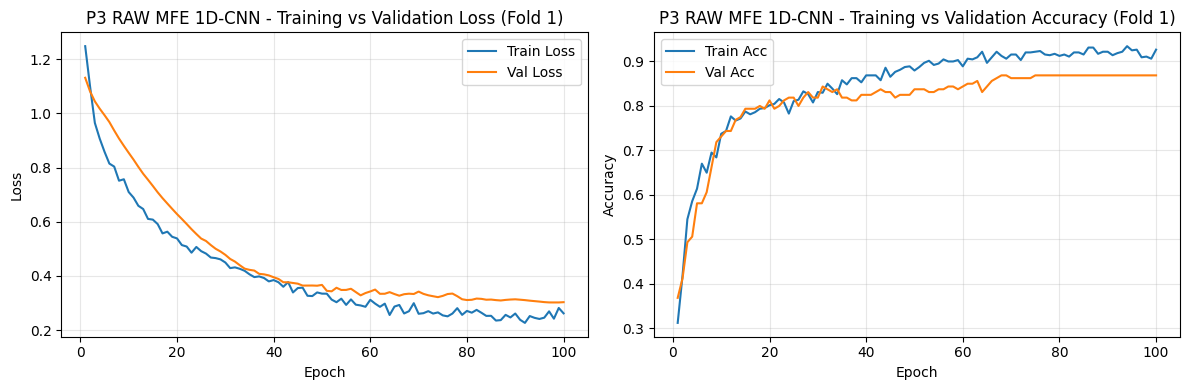

In [4]:
import os
import time
import random

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import psutil  # <-- untuk MemoryTracker

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: make GPU memory growth safe
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass


class Timer:
    """Simple wall-clock timer."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


class MemoryTracker:
    """
    Memory tracking utility (KB).
    Tracks baseline and peak RSS of the current process and
    returns delta (peak - baseline) dalam satuan KB.
    """
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self._get_current_memory()
        self.peak = self.baseline

    def _get_current_memory(self):
        # RSS dalam KB
        return self.process.memory_info().rss / 1024.0

    def update(self):
        current = self._get_current_memory()
        if current > self.peak:
            self.peak = current
        return current

    def get_usage(self):
        # Update sekali lagi di akhir dan kembalikan peak - baseline (KB)
        self.update()
        return self.peak - self.baseline


# =========================
# RAW MFE feature extractor
# =========================

class RawMFEExtractor:
    """
    Ekstraktor RAW Mel-Filterbank Energy untuk P3:

    - Sample rate: 44.1 kHz
    - Durasi: 1 detik
    - Frame length: 25 ms
    - Frame stride: 10 ms
    - n_fft: 2048
    - n_mels: 43

    Output: tensor (n_frames, n_mels) ~ (98, 43) berisi log-MFE yang
    sudah dinormalisasi secara kasar ke [0, 1].
    """

    def __init__(
        self,
        target_sr=44100,
        duration=1.0,
        frame_length=0.025,
        frame_stride=0.01,
        n_mels=43,
        n_fft=2048,
        snr_db=15.0,
    ):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_length = frame_length
        self.frame_stride = frame_stride
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.snr_db = snr_db

        self.target_len = int(self.target_sr * self.duration)
        self.hop_length = int(round(self.frame_stride * self.target_sr))
        self.win_length = int(round(self.frame_length * self.target_sr))

        # jumlah frame waktu (harusnya ~98)
        self.n_frames = 1 + (self.target_len - self.win_length) // self.hop_length

    def _preprocess(self, y, sr):
        # resample
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # fix duration (pad atau cut)
        if len(y) < self.target_len:
            y = np.pad(y, (0, self.target_len - len(y)), mode="constant")
        else:
            y = y[: self.target_len]

        # normalisasi amplitude ke [-1, 1]
        y = librosa.util.normalize(y)
        return y, self.target_sr

    def _augment_white_noise(self, y):
        """Augmentasi white noise SNR tertentu (opsional untuk kelas tertentu)."""
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))
        noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        y_noisy = y + noise
        y_noisy = librosa.util.normalize(y_noisy)
        return y_noisy

    def _mfe_tensor(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self._preprocess(y, sr)

        if apply_augmentation:
            y_proc = self._augment_white_noise(y_proc)

        # Mel-spectrogram -> log-MFE
        mel = librosa.feature.melspectrogram(
            y=y_proc,
            sr=sr_proc,
            n_mels=self.n_mels,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            fmin=80.0,
            fmax=sr_proc / 2.0,
            power=2.0,
            htk=False,
            norm="slaney",
        )  # (n_mels, T)

        log_mel = np.log(mel + 1e-8)  # raw MFE (log-energi)

        # pastikan jumlah frame = self.n_frames
        n_bands, T = log_mel.shape
        if T > self.n_frames:
            # ambil frame pertama self.n_frames
            log_mel = log_mel[:, : self.n_frames]
        elif T < self.n_frames:
            # pad dengan nilai minimum tiap band
            pad_width = self.n_frames - T
            pad_vals = np.min(log_mel, axis=1, keepdims=True)
            pad = np.repeat(pad_vals, pad_width, axis=1)
            log_mel = np.concatenate([log_mel, pad], axis=1)

        # transpose jadi (time, mel)
        feat = log_mel.T  # (n_frames, n_mels)

        # normalisasi kasar ke [0, 1] dengan asumsi rentang [-80, 0] dB
        min_db = -80.0
        max_db = 0.0
        feat_norm = (feat - min_db) / (max_db - min_db)
        feat_norm = np.clip(feat_norm, 0.0, 1.0)

        return feat_norm.astype(np.float32)

    def extract_from_file(self, filepath, label=None, augment_for_labels=None):
        """Return list of tensors: [original, (optional) augmented]."""
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = [self._mfe_tensor(y, sr, apply_augmentation=False)]

        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self._mfe_tensor(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader (RAW MFE)
# =========================

class AudioDatasetRawMFE:
    """
    Struktur folder:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav

    Hasil: X (N, n_frames, n_mels) dan y (label string),
    dengan augmentasi optional untuk kelas tertentu.
    """

    def __init__(
        self,
        base_dir,
        mfe_extractor,
        class_names=None,
        augment=True,
        augment_for=("ambulance", "firetruck"),
        max_files_per_class=None,
    ):
        self.base_dir = base_dir
        self.mfe = mfe_extractor
        self.augment = augment
        self.augment_for = set(augment_for)
        self.class_names = (
            class_names if class_names is not None else ["ambulance", "firetruck", "traffic"]
        )
        self.max_files_per_class = max_files_per_class

    def load(self):
        X_list = []
        y_list = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue

            files = [
                f
                for f in sorted(os.listdir(class_dir))
                if f.lower().endswith((".wav", ".flac", ".ogg", ".mp3", ".m4a"))
            ]

            if self.max_files_per_class is not None:
                files = files[: self.max_files_per_class]

            print(f"Processing {len(files)} files from {label}...")

            for fname in files:
                fpath = os.path.join(class_dir, fname)
                feats = self.mfe.extract_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None,
                )
                for feat in feats:
                    X_list.append(feat)
                    y_list.append(label)

        X = np.stack(X_list, axis=0)  # (N, n_frames, n_mels)
        y = np.array(y_list)
        return X, y


# =========================
# P3 model: RAW MFE 1D-CNN
# =========================

def build_p3_model(input_shape, num_classes,
                   dropout_rate=0.40,
                   l2_lambda=5e-4,
                   lr=0.5e-4):
    """
    P3: RAW MFE 1D-CNN (versi stabil & ringan)
    - Conv1D(8) → BN → MaxPool → Dropout
    - Conv1D(16) → BN → MaxPool → Dropout
    - GlobalAveragePooling1D
    - Dense(16) → Dropout
    - Dense(num_classes)
    """
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Block 2
    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(dropout_rate)(x)

    # Global pooling (lebih sedikit parameter daripada Flatten)
    x = layers.GlobalAveragePooling1D()(x)

    # Bottleneck kecil
    x = layers.Dense(
        16,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda),
    )(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="P3_RAW_MFE_1D_CNN")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# =========================
# Experiment runner (P3)
# =========================

def run_p3_experiment(
    data_dir,
    n_splits=5,
    epochs=100,
    batch_size=128,
    max_files_per_class=None,
):
    # 1. Ekstraksi fitur (RAW MFE) + memory
    mfe_extractor = RawMFEExtractor()
    dataset = AudioDatasetRawMFE(
        data_dir,
        mfe_extractor,
        max_files_per_class=max_files_per_class,
    )

    feat_timer = Timer()
    feat_mem = MemoryTracker()

    feat_timer.start()
    X_raw, y_labels = dataset.load()
    feat_timer.stop()
    feat_mem_usage = feat_mem.get_usage()

    n_samples = X_raw.shape[0]
    n_frames, n_mels = X_raw.shape[1], X_raw.shape[2]
    feat_time_total = feat_timer.get_elapsed()
    feat_time_per_sample = feat_time_total / max(n_samples, 1)

    class_counts = {c: int(np.sum(y_labels == c)) for c in np.unique(y_labels)}

    print("\n✅ Dataset loaded and RAW MFE features extracted (P3).")
    print(f"   Total samples (incl. augmentation): {n_samples}")
    print(f"   Feature tensor shape: {X_raw.shape}  (N, n_frames, n_mels)")
    print(f"   Total feature extraction time: {feat_time_total:.3f} s")
    print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
    print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} KB")
    print(f"   Class distribution: {class_counts}")

    # 2. Encode label
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)
    num_classes = len(label_encoder.classes_)

    # 3. K-Fold CV
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

    acc_list = []
    f1_list = []
    prec_list = []
    rec_list = []
    infer_time_per_sample_list = []
    mem_list = []  # <--- memory usage train+test per fold

    histories = []

    fold_idx = 1
    input_shape = (n_frames, n_mels)
    D = n_frames * n_mels

    print("\n================ P3 RAW MFE 1D-CNN: {}-Fold CV ================".format(n_splits))

    for train_index, test_index in skf.split(X_raw, y):
        print("\n" + "=" * 60)
        print(f"🔍 FOLD {fold_idx}/{n_splits}")
        print("=" * 60)

        X_train_full, X_test = X_raw[train_index], X_raw[test_index]
        y_train_full, y_test = y[train_index], y[test_index]

        # ---- Scaling: flatten -> StandardScaler -> reshape ----
        scaler = StandardScaler()

        X_train_flat = X_train_full.reshape(X_train_full.shape[0], D)
        X_test_flat = X_test.reshape(X_test.shape[0], D)

        X_train_scaled_flat = scaler.fit_transform(X_train_flat)
        X_test_scaled_flat = scaler.transform(X_test_flat)

        X_train_scaled = X_train_scaled_flat.reshape(-1, *input_shape)
        X_test_scaled = X_test_scaled_flat.reshape(-1, *input_shape)

        # ---- Split train menjadi train/val (internal) ----
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled,
            y_train_full,
            test_size=0.2,
            stratify=y_train_full,
            random_state=SEED,
        )

        print(f"   Train samples: {X_train.shape[0]}")
        print(f"   Val samples:   {X_val.shape[0]}")
        print(f"   Test samples:  {X_test_scaled.shape[0]}")

        # ---- Build & train model ----
        model = build_p3_model(
            input_shape=input_shape,
            num_classes=num_classes,
            dropout_rate=0.40,
            l2_lambda=5e-4,
            lr=5e-4
        )

        early_stop = EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            verbose=1,
        )
        reduce_lr = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1,
        )

        # Memory tracking train+test
        mem_tracker = MemoryTracker()

        history = model.fit(
            X_train,
            y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=2,
            callbacks=[early_stop, reduce_lr],
        )
        histories.append(history)
        mem_tracker.update()  # update setelah training

        # ---- Evaluate on test fold ----
        infer_timer = Timer()
        infer_timer.start()
        y_proba = model.predict(X_test_scaled, batch_size=batch_size, verbose=0)
        infer_timer.stop()
        mem_tracker.update()  # update setelah inference

        mem_usage = mem_tracker.get_usage()  # KB

        infer_time_per_sample = infer_timer.get_elapsed() / len(X_test_scaled)
        y_pred = np.argmax(y_proba, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        prec = precision_score(y_test, y_pred, average="macro")
        rec = recall_score(y_test, y_pred, average="macro")

        acc_list.append(acc)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
        infer_time_per_sample_list.append(infer_time_per_sample)
        mem_list.append(mem_usage)

        print(f"   Fold {fold_idx} accuracy: {acc:.4f}")
        print(f"   Fold {fold_idx} F1-macro: {f1:.4f}")
        print(f"   Fold {fold_idx} precision: {prec:.4f}, recall: {rec:.4f}")
        print(f"   Inference time per sample (test): {infer_time_per_sample:.6f} s")
        print(f"   Extra memory (train+test): {mem_usage:.2f} KB")

        fold_idx += 1

    # 4. Ringkasan
    summary_rows = []

    def mean_std_str(vals):
        return f"{np.mean(vals):.4f} ± {np.std(vals):.4f}"

    summary_rows.append(
        {
            "Model": "P3 RAW MFE 1D-CNN",
            "Accuracy (mean±std)": mean_std_str(acc_list),
            "F1 Score (mean±std)": mean_std_str(f1_list),
            "Precision (mean±std)": mean_std_str(prec_list),
            "Recall (mean±std)": mean_std_str(rec_list),
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{np.mean(infer_time_per_sample_list):.6f}",
            "Memory usage tambahan [KB] (train+test, mean)": f"{np.mean(mem_list):.2f}",
        }
    )

    results_df = pd.DataFrame(summary_rows)
    results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

    print("\n" + "=" * 80)
    print("HASIL {}-FOLD CROSS VALIDATION (P3: RAW MFE 1D-CNN)".format(n_splits))
    print("=" * 80)
    print(results_df.to_string(index=False))

    return results_df, histories


# =========================
# Plot training history
# =========================

def plot_training_history(histories, fold_to_plot=0, title_prefix="P3"):
    """
    Plot kurva training vs validation loss & accuracy
    untuk salah satu fold (default: fold pertama).
    """
    if not histories:
        print("No histories to plot.")
        return
    if fold_to_plot < 0 or fold_to_plot >= len(histories):
        print("Invalid fold index.")
        return

    history = histories[fold_to_plot]
    epochs = range(1, len(history.history["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["loss"], label="Train Loss")
    plt.plot(epochs, history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} - Training vs Validation Loss (Fold {fold_to_plot+1})")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["accuracy"], label="Train Acc")
    plt.plot(epochs, history.history["val_accuracy"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} - Training vs Validation Accuracy (Fold {fold_to_plot+1})")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# =========================
# Main
# =========================

if __name__ == "__main__":
    # Sesuaikan path dataset
    data_dir = "./sounds"

    # max_files_per_class bisa None atau integer (misal 100) kalau mau batasi
    results_p3, histories_p3 = run_p3_experiment(
        data_dir=data_dir,
        n_splits=5,
        epochs=100,
        batch_size=128,
        max_files_per_class=None,
    )

    # Tampilkan grafik training untuk fold pertama
    plot_training_history(histories_p3, fold_to_plot=0, title_prefix="P3 RAW MFE 1D-CNN")


# P4 dan P 5

In [ ]:
P4

✅ Dataset loaded and Stat-MFE features extracted for CNN.
   Total samples (incl. augmentation): 1000
   Feature dimension: 396
   Total feature extraction time: 19.135 s
   Avg feature extraction time per sample: 0.019135 s
   Extra memory during feature extraction: 11.50 MB

🔍 CNN FOLD 1/5

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 18.


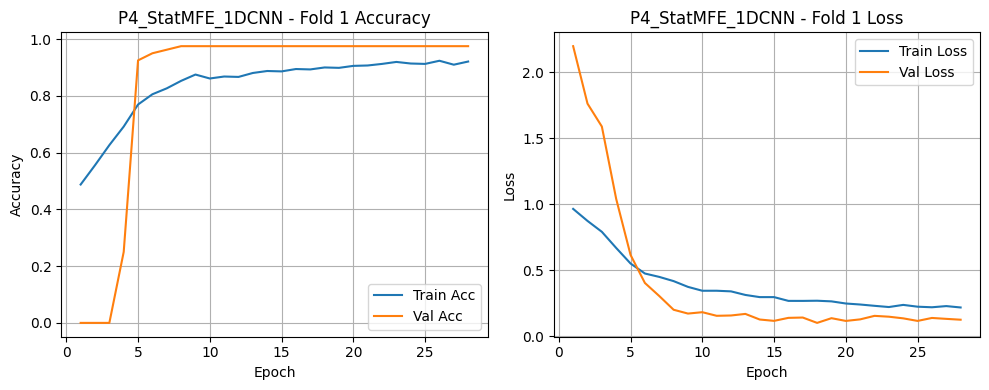

   P4_StatMFE_1DCNN fold accuracy: 0.9100, F1-macro: 0.9188
   P4_StatMFE_1DCNN inference time per sample (test): 0.000711 s
   P4_StatMFE_1DCNN extra memory (train+test): 10.25 MB

🔍 CNN FOLD 2/5

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.


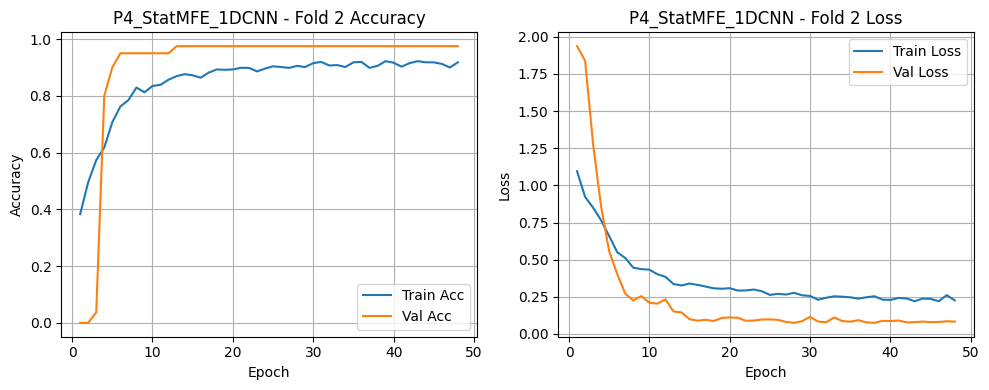

   P4_StatMFE_1DCNN fold accuracy: 0.9450, F1-macro: 0.9520
   P4_StatMFE_1DCNN inference time per sample (test): 0.000670 s
   P4_StatMFE_1DCNN extra memory (train+test): 12.47 MB

🔍 CNN FOLD 3/5

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 35: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 25.


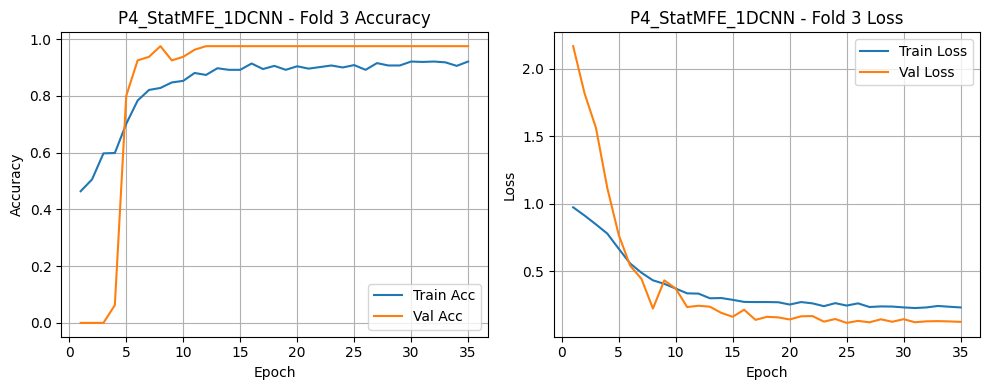

   P4_StatMFE_1DCNN fold accuracy: 0.9050, F1-macro: 0.9167
   P4_StatMFE_1DCNN inference time per sample (test): 0.000676 s
   P4_StatMFE_1DCNN extra memory (train+test): 10.87 MB

🔍 CNN FOLD 4/5

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 40.


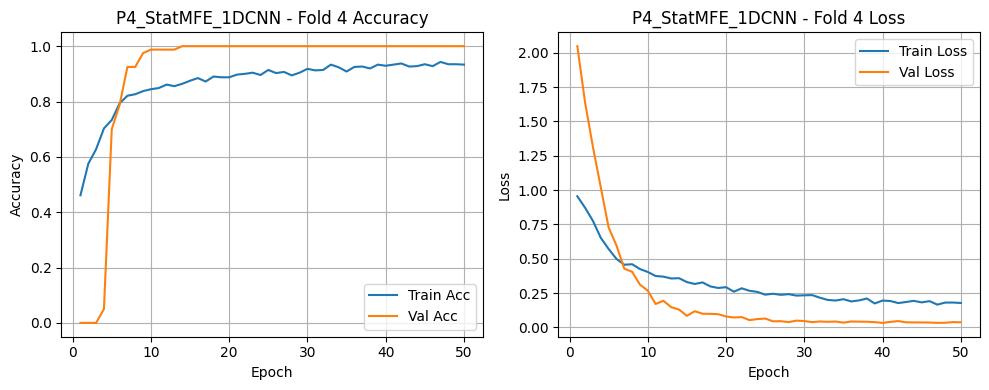

   P4_StatMFE_1DCNN fold accuracy: 0.9350, F1-macro: 0.9458
   P4_StatMFE_1DCNN inference time per sample (test): 0.000737 s
   P4_StatMFE_1DCNN extra memory (train+test): 15.64 MB

🔍 CNN FOLD 5/5

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 31.


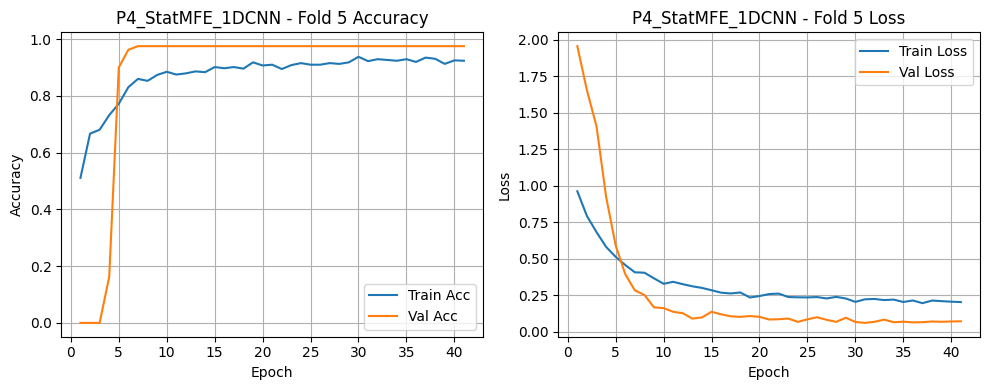

   P4_StatMFE_1DCNN fold accuracy: 0.9350, F1-macro: 0.9458
   P4_StatMFE_1DCNN inference time per sample (test): 0.000727 s
   P4_StatMFE_1DCNN extra memory (train+test): 13.39 MB

HASIL 5-FOLD CROSS VALIDATION (P4_StatMFE_1DCNN)
 No            Model Accuracy (mean±std) F1 Score (mean±std) Run Time Ekstraksi Fitur per Sampel [s] Run Time Inference per Sampel [s] (mean test) Memory usage tambahan [MB] (train+test, mean)
  1 P4_StatMFE_1DCNN     0.9260 ± 0.0156     0.9358 ± 0.0150                                0.019135                                      0.000704                                         12.52


In [3]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt


from scipy.signal import hilbert
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# === NEW: TensorFlow / Keras untuk CNN P4/P5 ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: amanin GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# =========================
# Utility classes
# =========================

class Timer:
    """Simple timer utility to measure elapsed wall-clock time (in seconds)."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


class MemoryTracker:
    """
    Memory tracking utility (MB).
    Tracks baseline and peak RSS of the current process and
    returns delta (peak - baseline).
    """
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self._get_current_memory()
        self.peak = self.baseline

    def _get_current_memory(self):
        return self.process.memory_info().rss / (1024 * 1024)

    def update(self):
        current = self._get_current_memory()
        if current > self.peak:
            self.peak = current
        return current

    def get_usage(self):
        # Update once more at the end and return peak - baseline
        self.update()
        return self.peak - self.baseline


class FeatureScaler:
    """
    Standardization (zero mean, unit variance)
    + Min-Max normalization to [0, 1].
    Fitted only on training data within each fold.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  # avoid division by zero

        X_std = (X - self.mean_) / self.std_

        self.min_ = X_std.min(axis=0)
        self.max_ = X_std.max(axis=0)
        same = self.max_ == self.min_
        self.max_[same] = self.min_[same] + 1.0  # avoid zero range

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_std = (X - self.mean_) / self.std_
        X_norm = (X_std - self.min_) / (self.max_ - self.min_)
        return X_norm

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# =========================
# Feature extraction
# =========================

class FeatureExtractor:
    """
    Modular feature pipeline (bisa untuk B1, B2, B3/PMFE, dan P4/P5 CNN):

    Grup fitur (bisa di-ON/OFF):
    - Time-domain: mean RMS, mean ZCR
    - Basic spectral: spectral centroid, bandwidth, roll-off
    - Min/Max freq: min & max freq > -40 dB
    - MFCC: 13 mean MFCC
    - MFE (Stat-MFE 396-D): 43 mel band × 9 statistik + 9 fitur global
    - Chroma: 12-dim chroma STFT (mean)
    - Doppler/motion: mean IF, mean chirp rate, mean spectral flux
    """

    def __init__(self,
                 target_sr=41000,
                 duration=3.0,
                 frame_size=1024,
                 hop_length=512,
                 snr_db=15.0,
                 use_time=True,
                 use_basic_spectral=True,
                 use_minmaxfreq=True,
                 use_mfcc=True,
                 use_mfe=False,
                 use_chroma=True,
                 use_doppler=True):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.snr_db = snr_db

        # flags modulasi fitur
        self.use_time = use_time
        self.use_basic_spectral = use_basic_spectral
        self.use_minmaxfreq = use_minmaxfreq
        self.use_mfcc = use_mfcc
        self.use_mfe = use_mfe
        self.use_chroma = use_chroma
        self.use_doppler = use_doppler

    # ---------- Preset helper ----------

    @classmethod
    def from_preset(cls, preset_name, **kwargs):
        """
        Helper untuk bikin FeatureExtractor sesuai preset:
        - "B1" / "all": semua fitur ON (baseline B1: All Features)
        - "mfcc_only": hanya MFCC
        - "spec_no_mfcc": centroid, SBW, roll-off, chroma, min/max freq,
                          + Doppler (IF, chirp, flux) tanpa MFCC, tanpa time.
        - "pmfe": hanya Stat-MFE 396-D (dipakai B3 & P4/P5).
        """
        preset = preset_name.lower()

        base = dict(
            target_sr=41000,
            duration=3.0,
            frame_size=1024,
            hop_length=512,
            snr_db=15.0,
            use_time=True,
            use_basic_spectral=True,
            use_minmaxfreq=True,
            use_mfcc=True,
            use_mfe=False,
            use_chroma=True,
            use_doppler=True,
        )

        if preset in ("b1", "b1_all", "all"):
            # B1: All features (time + all spectral + doppler)
            pass  # pakai base apa adanya
        elif preset in ("b2_mfcc", "mfcc_only"):
            # B2: hanya MFCC (single feature group)
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=True,
                use_chroma=False,
                use_doppler=False,
            ))
        elif preset in ("spec_no_mfcc", "spectral_no_mfcc"):
            # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
            base.update(dict(
                use_time=False,
                use_basic_spectral=True,
                use_minmaxfreq=True,
                use_mfcc=False,
                use_chroma=True,
                use_doppler=True,
            ))
        elif preset in ("pmfe", "mfe_only", "proposed_mfe"):
            # B3/P1/P4/P5: hanya Mel Filterbank Energy (Stat-MFE 396-D) saja
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=False,
                use_mfe=True,
                use_chroma=False,
                use_doppler=False,
            ))
        else:
            raise ValueError(f"Unknown feature preset: {preset_name}")

        # allow override
        base.update(kwargs)
        return cls(**base)

    # ---------- Preprocessing ----------

    def preprocess(self, y, sr):
        # Resample if needed
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # Fixed duration
        target_len = int(self.duration * self.target_sr)
        if len(y) > target_len:
            y = y[:target_len]
        elif len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # Normalize amplitude to [-1, 1]
        max_amp = np.max(np.abs(y)) + 1e-12
        y = y / max_amp
        return y, self.target_sr

    # ---------- Augmentation ----------

    def augment(self, y):
        """
        White noise at target SNR with dynamic factor 0.5–1.5.
        Signal dan noise dinormalisasi sebelum dicampur.
        """
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))

        white_noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        dynamic_factor = np.random.uniform(0.5, 1.5, size=len(y))
        noise = white_noise * dynamic_factor

        sig_max = np.max(np.abs(y)) + 1e-12
        noise_max = np.max(np.abs(noise)) + 1e-12
        y_norm = y / sig_max
        noise_norm = noise / noise_max

        y_aug = y_norm + noise_norm
        y_aug = y_aug / (np.max(np.abs(y_aug)) + 1e-12)
        return y_aug

    # ---------- Time-domain ----------

    def extract_time_domain_features(self, y):
        frames = librosa.util.frame(
            y,
            frame_length=self.frame_size,
            hop_length=self.hop_length
        ).T  # (n_frames, frame_size)

        rms = np.sqrt(np.mean(frames ** 2, axis=1))

        sign_changes = np.diff(np.sign(frames), axis=1) != 0
        zcr = sign_changes.sum(axis=1) / (2.0 * frames.shape[1])

        mean_rms = float(np.mean(rms))
        mean_zcr = float(np.mean(zcr))
        return np.array([mean_rms, mean_zcr], dtype=np.float64)

    # ---------- Spectrogram helper ----------

    def _compute_spectrogram(self, y):
        """
        Compute STFT + derived matrices once, supaya bisa dipakai
        oleh beberapa grup fitur tanpa menghitung ulang.
        """
        stft = librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        )
        P = np.abs(stft) ** 2  # power spectrogram (n_freqs, n_frames)
        freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=self.frame_size)
        S_db = librosa.power_to_db(P, ref=np.max)
        return stft, P, freqs, S_db

    # ---------- Basic spectral: centroid, bandwidth, rolloff ----------

    def extract_basic_spectral_features(self, P, freqs):
        magnitude_sum = P.sum(axis=0) + 1e-12
        centroid = (freqs[:, None] * P).sum(axis=0) / magnitude_sum

        diff = freqs[:, None] - centroid[None, :]
        variance = (diff ** 2 * P).sum(axis=0) / magnitude_sum
        bandwidth = np.sqrt(variance)

        mean_centroid = float(np.mean(centroid))
        mean_bandwidth = float(np.mean(bandwidth))

        rolloff = librosa.feature.spectral_rolloff(
            S=P,
            sr=self.target_sr,
            roll_percent=0.85
        )[0]
        mean_rolloff = float(np.mean(rolloff))

        return np.array(
            [mean_centroid, mean_bandwidth, mean_rolloff],
            dtype=np.float64
        )

    # ---------- Min / Max frequency > -40 dB ----------

    def extract_minmaxfreq_features(self, S_db, freqs):
        significant = S_db > -40
        min_freqs = []
        max_freqs = []
        for t in range(significant.shape[1]):
            idx = np.where(significant[:, t])[0]
            if idx.size > 0:
                min_freqs.append(freqs[idx[0]])
                max_freqs.append(freqs[idx[-1]])
            else:
                min_freqs.append(0.0)
                max_freqs.append(0.0)
        mean_min_freq = float(np.mean(min_freqs))
        mean_max_freq = float(np.mean(max_freqs))
        return np.array([mean_min_freq, mean_max_freq], dtype=np.float64)

    # ---------- MFCC ----------

    def extract_mfcc_features(self, P):
        mfcc = librosa.feature.mfcc(
            S=librosa.power_to_db(P),
            sr=self.target_sr,
            n_mfcc=13
        )
        mean_mfcc = mfcc.mean(axis=1)  # (13,)
        return mean_mfcc.astype(np.float64)

    # ---------- NEW: Proposed Stat-MFE 396-D (P4/P5) ----------
    def extract_mfe_features(self, P):
        """
        Statistical Mel-Filterbank Energy (Stat-MFE) untuk P4/P5-style:
        - Hitung mel-spectrogram (log-mel) dengan 43 mel bands.
        - Untuk setiap mel band: 9 statistik sepanjang waktu
          [mean, std, min, max, median, p10, p90, p25, p75]
        - Tambah 9 fitur global dengan statistik yang sama di seluruh koefisien mel.
        - Output: 43 bands × 9 stats + 9 global = 396-D.
        """
        n_mels = 43

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            n_mels=n_mels
        )  # (43, n_frames)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (43, n_frames)

        def _nine_stats(x):
            x = np.asarray(x, dtype=np.float64)
            return np.array([
                np.mean(x),
                np.std(x),
                np.min(x),
                np.max(x),
                np.median(x),
                np.percentile(x, 10),
                np.percentile(x, 90),
                np.percentile(x, 25),
                np.percentile(x, 75),
            ], dtype=np.float64)

        # Statistik per mel band
        band_stats = []
        for b in range(n_mels):
            band_stats.append(_nine_stats(mel_db[b, :]))
        band_stats = np.stack(band_stats, axis=0)  # (43, 9)

        # 9 fitur global (seluruh koef mel)
        global_stats = _nine_stats(mel_db.reshape(-1))[None, :]  # (1, 9)

        # (44,9) → flatten ke 396-D
        full_stats = np.vstack([band_stats, global_stats])  # (44, 9)
        stat_mfe = full_stats.reshape(-1)  # (396,)
        return stat_mfe

    # ---------- Chroma ----------

    def extract_chroma_features(self, stft):
        chroma = librosa.feature.chroma_stft(
            S=np.abs(stft),
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length
        )
        mean_chroma = chroma.mean(axis=1)  # (12,)
        return mean_chroma.astype(np.float64)

    # ---------- Doppler / motion ----------

    def extract_doppler_features(self, y):
        analytic = hilbert(y)
        phase = np.unwrap(np.angle(analytic))
        dt = 1.0 / self.target_sr
        inst_freq = np.diff(phase) / (2.0 * np.pi * dt)
        mean_if = float(np.mean(inst_freq))

        chirp_rate = np.diff(inst_freq) / dt
        mean_chirp = float(np.mean(chirp_rate))

        stft_mag = np.abs(librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        ))
        norm = stft_mag.sum(axis=0, keepdims=True) + 1e-12
        S_norm = stft_mag / norm

        flux_values = []
        prev = np.zeros(S_norm.shape[0])
        for t in range(S_norm.shape[1]):
            cur = S_norm[:, t]
            flux = np.sum(np.maximum(cur - prev, 0.0))
            flux_values.append(flux)
            prev = cur
        mean_flux = float(np.mean(flux_values))

        return np.array([mean_if, mean_chirp, mean_flux], dtype=np.float64)

    # ---------- Public API ----------

    def extract_features_from_signal(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self.preprocess(y, sr)
        if apply_augmentation:
            y_proc = self.augment(y_proc)

        features = []

        # Time-domain
        if self.use_time:
            features.append(self.extract_time_domain_features(y_proc))

        # Spectral-domain (pakai STFT shared kalau perlu)
        need_spectral = any([
            self.use_basic_spectral,
            self.use_minmaxfreq,
            self.use_mfcc,
            self.use_mfe,       # <--- pakai P4/P5 Stat-MFE
            self.use_chroma,
        ])

        stft = P = freqs = S_db = None
        if need_spectral:
            stft, P, freqs, S_db = self._compute_spectrogram(y_proc)

        # Urutan dibuat match dengan B1 lama:
        if self.use_basic_spectral and P is not None:
            features.append(self.extract_basic_spectral_features(P, freqs))

        if self.use_minmaxfreq and S_db is not None:
            features.append(self.extract_minmaxfreq_features(S_db, freqs))

        if self.use_mfcc and P is not None:
            features.append(self.extract_mfcc_features(P))

        if self.use_mfe and P is not None:
            features.append(self.extract_mfe_features(P))

        if self.use_chroma and stft is not None:
            features.append(self.extract_chroma_features(stft))

        # Doppler / motion
        if self.use_doppler:
            features.append(self.extract_doppler_features(y_proc))

        if not features:
            raise ValueError("No feature groups enabled in FeatureExtractor.")

        full_feat = np.concatenate(features, axis=0)
        return full_feat

    def extract_features_from_file(self, filepath, label=None, augment_for_labels=None):
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = []
        # Original
        feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=False))

        # Augmented (only for some labels)
        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader
# =========================

class AudioDataset:
    """
    Folder structure:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav
    """
    def __init__(self, base_dir, feature_extractor,
                 class_names=None,
                 augment=True,
                 augment_for=("ambulance", "firetruck")):
        self.base_dir = base_dir
        self.fe = feature_extractor
        self.augment = augment
        if class_names is None:
            self.class_names = ["ambulance", "firetruck", "traffic"]
        else:
            self.class_names = class_names
        self.augment_for = set(augment_for)

    def load(self):
        X = []
        y = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                if not fname.lower().endswith(".wav"):
                    continue
                fpath = os.path.join(class_dir, fname)
                features_list = self.fe.extract_features_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None
                )
                for feat in features_list:
                    X.append(feat)
                    y.append(label)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        return X, y

# =========================
# Classical ML models (B1/B2/B3)
# =========================

def create_base_models():
    """Base classifiers untuk B1/B2/B3."""
    models = {
        "SVM": SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=True,
            random_state=SEED
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=3,
            weights="distance"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=SEED,
            n_jobs=-1
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=SEED
        )
    }
    return models


class StackedEnsemble:
    """
    Stacked ensemble:
    - Base: SVM, KNN, RF, AdaBoost (probability outputs)
    - Meta-learner: SVM (rbf)
    """
    def __init__(self, base_models, meta_learner=None):
        self.base_models = base_models
        if meta_learner is None:
            self.meta_learner = SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=False,
                random_state=SEED
            )
        else:
            self.meta_learner = meta_learner

    def fit(self, X_train, y_train):
        X_base, X_meta, y_base, y_meta = train_test_split(
            X_train, y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=SEED
        )

        for model in self.base_models.values():
            model.fit(X_base, y_base)

        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X_meta)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)

        self.meta_learner.fit(meta_X, y_meta)

    def predict(self, X):
        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)
        y_pred = self.meta_learner.predict(meta_X)
        return y_pred

# =========================
# Experiment runner (B1/B2/B3)
# =========================

class ExperimentRunner:
    def __init__(self, data_dir, feature_preset="B1"):
        self.data_dir = data_dir
        # pakai preset B1 (all features) sebagai default
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()

    def run(self, n_splits=5):
        # 1. Feature extraction timing (seluruh dataset, termasuk augment)
        feat_timer = Timer()
        feat_mem = MemoryTracker()

        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem_usage = feat_mem.get_usage()

        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and features extracted.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        # Encode labels (0,1,2)
        y = self.label_encoder.fit_transform(y_labels)

        # 2. Cross-validation setup
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        model_names = ["SVM", "KNN", "RandomForest", "AdaBoost", "StackedEnsemble"]
        acc_logs = {name: [] for name in model_names}
        f1_logs = {name: [] for name in model_names}
        infer_time_logs = {name: [] for name in model_names}  # per-sample on test set
        mem_logs = {name: [] for name in model_names}         # train+test peak

        fold_idx = 1
        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling (fit only on training fold)
            scaler = FeatureScaler()
            X_train = scaler.fit_transform(X_train_raw)
            X_test = scaler.transform(X_test_raw)

            # --- Base models ---
            base_models = create_base_models()

            for name, model in base_models.items():
                print(f"\n▶ Training {name}...")

                mem_tracker = MemoryTracker()
                train_timer = Timer()
                infer_timer = Timer()

                # Train
                train_timer.start()
                model.fit(X_train, y_train)
                train_timer.stop()
                mem_tracker.update()

                # Inference on test set
                infer_timer.start()
                y_pred = model.predict(X_test)
                infer_timer.stop()
                mem_tracker.update()

                mem_usage = mem_tracker.get_usage()
                infer_time_total = infer_timer.get_elapsed()
                infer_time_per_sample = infer_time_total / len(X_test)

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average="macro")

                acc_logs[name].append(acc)
                f1_logs[name].append(f1)
                infer_time_logs[name].append(infer_time_per_sample)
                mem_logs[name].append(mem_usage)

                print(f"   {name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
                print(f"   {name} inference time per sample (test): {infer_time_per_sample:.6f} s")
                print(f"   {name} extra memory (train+test): {mem_usage:.2f} MB")

            # --- Stacked ensemble ---
            print("\n▶ Training Stacked Ensemble (base: SVM, KNN, RF, AdaBoost; meta: SVM)...")
            ensemble_base_models = create_base_models()
            ensemble = StackedEnsemble(ensemble_base_models)

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train ensemble
            train_timer.start()
            ensemble.fit(X_train, y_train)
            train_timer.stop()
            mem_tracker.update()

            # Inference on test set
            infer_timer.start()
            y_pred_ens = ensemble.predict(X_test)
            infer_timer.stop()
            mem_tracker.update()

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test)

            acc = accuracy_score(y_test, y_pred_ens)
            f1 = f1_score(y_test, y_pred_ens, average="macro")

            name = "StackedEnsemble"
            acc_logs[name].append(acc)
            f1_logs[name].append(f1)
            infer_time_logs[name].append(infer_time_per_sample)
            mem_logs[name].append(mem_usage)

            print(f"   Stacked Ensemble fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   Stacked Ensemble inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   Stacked Ensemble extra memory (train+test): {mem_usage:.2f} MB")

            fold_idx += 1

        # 3. Summarize across folds
        summary_rows = []
        for name in model_names:
            acc_mean = np.mean(acc_logs[name])
            acc_std = np.std(acc_logs[name])
            f1_mean = np.mean(f1_logs[name])
            f1_std = np.std(f1_logs[name])
            infer_mean = np.mean(infer_time_logs[name])
            mem_mean = np.mean(mem_logs[name])

            summary_rows.append({
                "Model": name,
                "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
                "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
                "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
                "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
                "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
            })

        results_df = pd.DataFrame(summary_rows)
        results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

        print("\n" + "=" * 80)
        print("HASIL 5-FOLD CROSS VALIDATION (Baseline B1/B2/B3: All ML)")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df

# =========================
# NEW: P4/P5-style 1D-CNN untuk Stat-MFE 396-D
# =========================

def build_p4_p5_cnn(input_shape, num_classes,
                    dropout_rate=0.30,
                    l2_lambda=1e-4,
                    lr=1e-3):
    """
    2-layer Conv1D (8→16) ala P4/P5:
    input: (44, 9)  # 44 "time steps" × 9 statistik
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
class CNNExperimentRunner:
    """
    Runner khusus P4/P5-style CNN:
    - Fitur: preset "pmfe" (Stat-MFE 396-D)
    - Reshape ke (44, 9)
    - Model: 2-layer Conv1D (8→16) + Dense 32 + Softmax
    """
    def __init__(self, data_dir,
                 feature_preset="pmfe",
                 cnn_name="P4_StatMFE_1DCNN"):
        self.data_dir = data_dir
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()
        self.cnn_name = cnn_name

    # --- helper untuk load data + waktu ekstraksi ---
    def _prepare_dataset(self):
        feat_timer = Timer()
        feat_mem = MemoryTracker()

        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem_usage = feat_mem.get_usage()

        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and Stat-MFE features extracted for CNN.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        return X_raw, y_labels, feat_time_per_sample

    # --- NEW: helper untuk plot history train vs val ---
    def _plot_history(self, history, fold_idx):
        """Plot accuracy & loss train vs val per epoch untuk 1 fold."""
        acc = history.history.get("accuracy", [])
        val_acc = history.history.get("val_accuracy", [])
        loss = history.history.get("loss", [])
        val_loss = history.history.get("val_loss", [])

        if not acc:  # kalau history kosong, skip aja
            print("⚠️ History kosong, tidak ada grafik yang bisa diplot.")
            return

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(10, 4))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self, n_splits=5, epochs=100, batch_size=32, plot_each_fold=True):
        X_raw, y_labels, feat_time_per_sample = self._prepare_dataset()

        y = self.label_encoder.fit_transform(y_labels)
        num_classes = len(self.label_encoder.classes_)

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        acc_logs = []
        f1_logs = []
        infer_time_logs = []
        mem_logs = []

        fold_idx = 1
        last_history = None  # simpan history fold terakhir

        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 CNN FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling
            scaler = FeatureScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)

            n_features = X_train_scaled.shape[1]
            channels = 9
            if n_features % channels != 0:
                raise ValueError(
                    f"Feature dimension {n_features} not divisible by {channels}; "
                    "tidak bisa reshape ke (time_steps, 9) untuk CNN."
                )
            time_steps = n_features // channels  # 396/9 = 44

            X_train_cnn = X_train_scaled.reshape(-1, time_steps, channels)
            X_test_cnn = X_test_scaled.reshape(-1, time_steps, channels)

            input_shape = (time_steps, channels)
            model = build_p4_p5_cnn(input_shape, num_classes)

            callbacks = [
                EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    restore_best_weights=True,
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    min_lr=1e-5,
                    verbose=1
                ),
            ]

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train
            train_timer.start()
            history = model.fit(
                X_train_cnn,
                y_train,
                validation_split=0.1,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                callbacks=callbacks,
            )
            train_timer.stop()
            mem_tracker.update()

            last_history = history  # simpan history terakhir

            # OPTIONAL: plot setiap fold
            if plot_each_fold:
                self._plot_history(history, fold_idx)

            # Inference
            infer_timer.start()
            y_proba = model.predict(
                X_test_cnn,
                batch_size=batch_size,
                verbose=0
            )
            infer_timer.stop()
            mem_tracker.update()

            y_pred = np.argmax(y_proba, axis=1)

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test_cnn)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")

            acc_logs.append(acc)
            f1_logs.append(f1)
            infer_time_logs.append(infer_time_per_sample)
            mem_logs.append(mem_usage)

            print(f"   {self.cnn_name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   {self.cnn_name} inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   {self.cnn_name} extra memory (train+test): {mem_usage:.2f} MB")

            fold_idx += 1
            tf.keras.backend.clear_session()

        # Kalau tidak plot per fold, plot sekali untuk fold terakhir
        if not plot_each_fold and last_history is not None:
            self._plot_history(last_history, fold_idx - 1)

        # Summary
        acc_mean = np.mean(acc_logs)
        acc_std = np.std(acc_logs)
        f1_mean = np.mean(f1_logs)
        f1_std = np.std(f1_logs)
        infer_mean = np.mean(infer_time_logs)
        mem_mean = np.mean(mem_logs)

        results_df = pd.DataFrame([{
            "Model": self.cnn_name,
            "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
            "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
            "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
        }])
        results_df.insert(0, "No", [1])

        print("\n" + "=" * 80)
        print(f"HASIL 5-FOLD CROSS VALIDATION ({self.cnn_name})")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df


# =========================
# Main
# =========================

if __name__ == "__main__":
    data_dir = "./sounds"

    # --- Baseline B1/B2/B3 (SVM, KNN, RF, AdaBoost, Stacked) ---
    # runner_b1 = ExperimentRunner(data_dir, feature_preset="B1")
    # results_b1 = runner_b1.run(n_splits=5)

    # runner_b2 = ExperimentRunner(data_dir, feature_preset="mfcc_only")
    # results_b2 = runner_b2.run(n_splits=5)

    # runner_spec = ExperimentRunner(data_dir, feature_preset="spec_no_mfcc")
    # results_spec = runner_spec.run(n_splits=5)

    # B3 / PMFE: Stat-MFE 396-D + classical ML
    # runner_pmfe = ExperimentRunner(data_dir, feature_preset="pmfe")
    # results_pmfe = runner_pmfe.run(n_splits=5)

    # --- NEW: P4/P5-style CNN di atas Stat-MFE 396-D ---
    cnn_runner_p4 = CNNExperimentRunner(
        data_dir,
        feature_preset="pmfe",
        cnn_name="P4_StatMFE_1DCNN"
    )
    results_p4 = cnn_runner_p4.run(n_splits=5, epochs=100, batch_size=32,plot_each_fold=True)

## P5

✅ Dataset loaded and Stat-MFE features extracted for CNN.
   Total samples (incl. augmentation): 1000
   Feature dimension: 396
   Total feature extraction time: 15.162 s
   Avg feature extraction time per sample: 0.015162 s
   Extra memory during feature extraction: 5.66 MB

🔍 CNN FOLD 1/5

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 25.


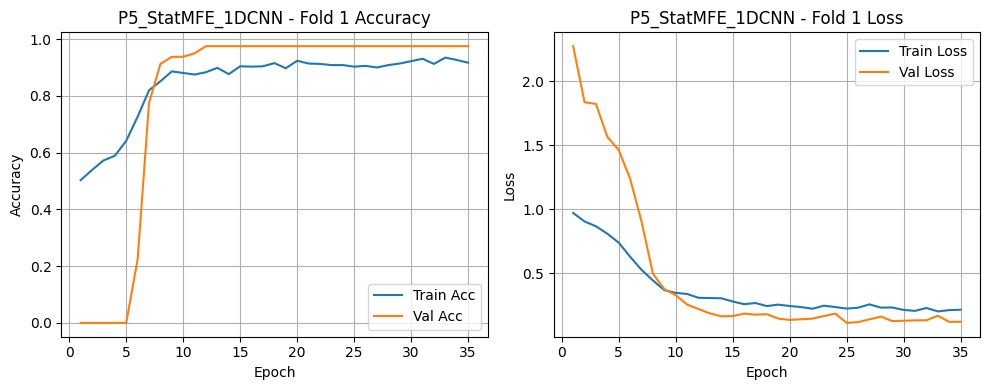

   P5_StatMFE_1DCNN fold accuracy: 0.9100, F1-macro: 0.9231
   P5_StatMFE_1DCNN inference time per sample (test): 0.000653 s
   P5_StatMFE_1DCNN extra memory (train+test): 13.60 MB

🔍 CNN FOLD 2/5

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 44: early stopping
Restoring model weights from the end of the best epoch: 34.


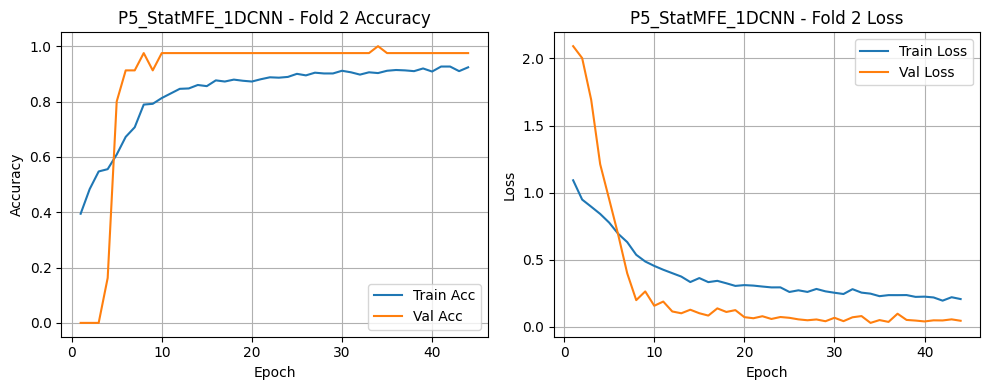

   P5_StatMFE_1DCNN fold accuracy: 0.9300, F1-macro: 0.9394
   P5_StatMFE_1DCNN inference time per sample (test): 0.000678 s
   P5_StatMFE_1DCNN extra memory (train+test): 13.70 MB

🔍 CNN FOLD 3/5

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 32.


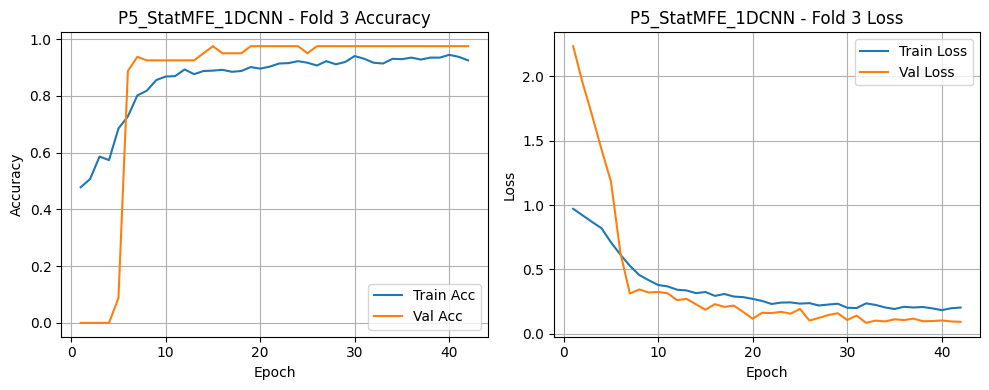

   P5_StatMFE_1DCNN fold accuracy: 0.9400, F1-macro: 0.9458
   P5_StatMFE_1DCNN inference time per sample (test): 0.000850 s
   P5_StatMFE_1DCNN extra memory (train+test): 12.96 MB

🔍 CNN FOLD 4/5

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 36.


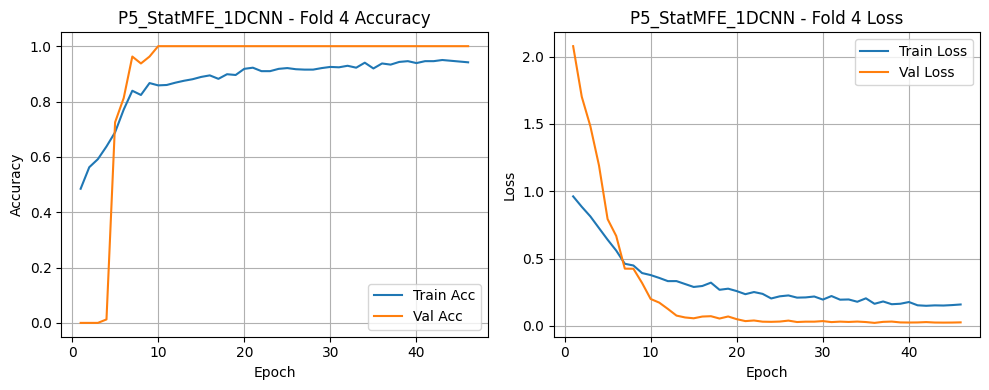

   P5_StatMFE_1DCNN fold accuracy: 0.9350, F1-macro: 0.9458
   P5_StatMFE_1DCNN inference time per sample (test): 0.000712 s
   P5_StatMFE_1DCNN extra memory (train+test): 13.19 MB

🔍 CNN FOLD 5/5

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 34: early stopping
Restoring model weights from the end of the best epoch: 24.


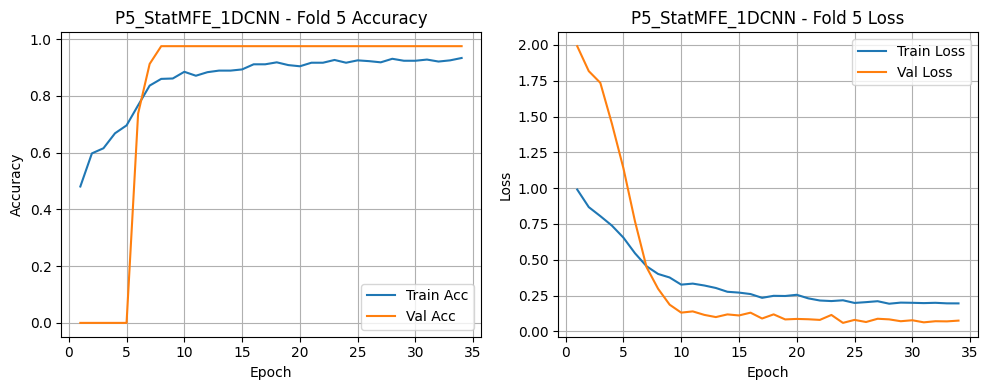

   P5_StatMFE_1DCNN fold accuracy: 0.9450, F1-macro: 0.9542
   P5_StatMFE_1DCNN inference time per sample (test): 0.000775 s
   P5_StatMFE_1DCNN extra memory (train+test): 12.87 MB

HASIL 5-FOLD CROSS VALIDATION (P5_StatMFE_1DCNN)
 No            Model Accuracy (mean±std) F1 Score (mean±std) Run Time Ekstraksi Fitur per Sampel [s] Run Time Inference per Sampel [s] (mean test) Memory usage tambahan [MB] (train+test, mean)
  1 P5_StatMFE_1DCNN     0.9320 ± 0.0121     0.9417 ± 0.0104                                0.015162                                      0.000733                                         13.26


In [2]:
import os
import time
import random
import psutil
import numpy as np
import librosa
import pandas as pd
import matplotlib.pyplot as plt


from scipy.signal import hilbert
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# === NEW: TensorFlow / Keras untuk CNN P4/P5 ===
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# =========================
# Global configuration
# =========================

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: amanin GPU memory growth
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception:
        pass

# =========================
# Utility classes
# =========================

class Timer:
    """Simple timer utility to measure elapsed wall-clock time (in seconds)."""
    def __init__(self):
        self.start_time = None
        self.elapsed = 0.0

    def start(self):
        self.start_time = time.perf_counter()

    def stop(self):
        if self.start_time is not None:
            self.elapsed += time.perf_counter() - self.start_time
            self.start_time = None
        return self.elapsed

    def reset(self):
        self.start_time = None
        self.elapsed = 0.0

    def get_elapsed(self):
        return self.elapsed


class MemoryTracker:
    """
    Memory tracking utility (MB).
    Tracks baseline and peak RSS of the current process and
    returns delta (peak - baseline).
    """
    def __init__(self):
        self.process = psutil.Process(os.getpid())
        self.baseline = self._get_current_memory()
        self.peak = self.baseline

    def _get_current_memory(self):
        return self.process.memory_info().rss / (1024 * 1024)

    def update(self):
        current = self._get_current_memory()
        if current > self.peak:
            self.peak = current
        return current

    def get_usage(self):
        # Update once more at the end and return peak - baseline
        self.update()
        return self.peak - self.baseline


class FeatureScaler:
    """
    Standardization (zero mean, unit variance)
    + Min-Max normalization to [0, 1].
    Fitted only on training data within each fold.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None
        self.min_ = None
        self.max_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float64)
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  # avoid division by zero

        X_std = (X - self.mean_) / self.std_

        self.min_ = X_std.min(axis=0)
        self.max_ = X_std.max(axis=0)
        same = self.max_ == self.min_
        self.max_[same] = self.min_[same] + 1.0  # avoid zero range

    def transform(self, X):
        X = np.asarray(X, dtype=np.float64)
        X_std = (X - self.mean_) / self.std_
        X_norm = (X_std - self.min_) / (self.max_ - self.min_)
        return X_norm

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# =========================
# Feature extraction
# =========================

class FeatureExtractor:
    """
    Modular feature pipeline (bisa untuk B1, B2, B3/PMFE, dan P4/P5 CNN):

    Grup fitur (bisa di-ON/OFF):
    - Time-domain: mean RMS, mean ZCR
    - Basic spectral: spectral centroid, bandwidth, roll-off
    - Min/Max freq: min & max freq > -40 dB
    - MFCC: 13 mean MFCC
    - MFE (Stat-MFE 396-D): 43 mel band × 9 statistik + 9 fitur global
    - Chroma: 12-dim chroma STFT (mean)
    - Doppler/motion: mean IF, mean chirp rate, mean spectral flux
    """

    def __init__(self,
                 target_sr=16000,
                 duration=3.0,
                 frame_size=1024,
                 hop_length=512,
                 snr_db=15.0,
                 use_time=True,
                 use_basic_spectral=True,
                 use_minmaxfreq=True,
                 use_mfcc=True,
                 use_mfe=False,
                 use_chroma=True,
                 use_doppler=True):
        self.target_sr = target_sr
        self.duration = duration
        self.frame_size = frame_size
        self.hop_length = hop_length
        self.snr_db = snr_db

        # flags modulasi fitur
        self.use_time = use_time
        self.use_basic_spectral = use_basic_spectral
        self.use_minmaxfreq = use_minmaxfreq
        self.use_mfcc = use_mfcc
        self.use_mfe = use_mfe
        self.use_chroma = use_chroma
        self.use_doppler = use_doppler

    # ---------- Preset helper ----------

    @classmethod
    def from_preset(cls, preset_name, **kwargs):
        """
        Helper untuk bikin FeatureExtractor sesuai preset:
        - "B1" / "all": semua fitur ON (baseline B1: All Features)
        - "mfcc_only": hanya MFCC
        - "spec_no_mfcc": centroid, SBW, roll-off, chroma, min/max freq,
                          + Doppler (IF, chirp, flux) tanpa MFCC, tanpa time.
        - "pmfe": hanya Stat-MFE 396-D (dipakai B3 & P4/P5).
        """
        preset = preset_name.lower()

        base = dict(
            target_sr=16000,
            duration=3.0,
            frame_size=1024,
            hop_length=512,
            snr_db=15.0,
            use_time=True,
            use_basic_spectral=True,
            use_minmaxfreq=True,
            use_mfcc=True,
            use_mfe=False,
            use_chroma=True,
            use_doppler=True,
        )

        if preset in ("b1", "b1_all", "all"):
            # B1: All features (time + all spectral + doppler)
            pass  # pakai base apa adanya
        elif preset in ("b2_mfcc", "mfcc_only"):
            # B2: hanya MFCC (single feature group)
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=True,
                use_chroma=False,
                use_doppler=False,
            ))
        elif preset in ("spec_no_mfcc", "spectral_no_mfcc"):
            # Ablasi: centroid, SBW, roll-off, chroma, min/max freq, IF, chirp, flux
            base.update(dict(
                use_time=False,
                use_basic_spectral=True,
                use_minmaxfreq=True,
                use_mfcc=False,
                use_chroma=True,
                use_doppler=True,
            ))
        elif preset in ("pmfe", "mfe_only", "proposed_mfe"):
            # B3/P1/P4/P5: hanya Mel Filterbank Energy (Stat-MFE 396-D) saja
            base.update(dict(
                use_time=False,
                use_basic_spectral=False,
                use_minmaxfreq=False,
                use_mfcc=False,
                use_mfe=True,
                use_chroma=False,
                use_doppler=False,
            ))
        else:
            raise ValueError(f"Unknown feature preset: {preset_name}")

        # allow override
        base.update(kwargs)
        return cls(**base)

    # ---------- Preprocessing ----------

    def preprocess(self, y, sr):
        # Resample if needed
        if sr != self.target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=self.target_sr)

        # Fixed duration
        target_len = int(self.duration * self.target_sr)
        if len(y) > target_len:
            y = y[:target_len]
        elif len(y) < target_len:
            pad_width = target_len - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # Normalize amplitude to [-1, 1]
        max_amp = np.max(np.abs(y)) + 1e-12
        y = y / max_amp
        return y, self.target_sr

    # ---------- Augmentation ----------

    def augment(self, y):
        """
        White noise at target SNR with dynamic factor 0.5–1.5.
        Signal dan noise dinormalisasi sebelum dicampur.
        """
        signal_power = np.mean(y ** 2)
        noise_power = signal_power / (10.0 ** (self.snr_db / 10.0))

        white_noise = np.random.normal(0.0, np.sqrt(noise_power), size=len(y))
        dynamic_factor = np.random.uniform(0.5, 1.5, size=len(y))
        noise = white_noise * dynamic_factor

        sig_max = np.max(np.abs(y)) + 1e-12
        noise_max = np.max(np.abs(noise)) + 1e-12
        y_norm = y / sig_max
        noise_norm = noise / noise_max

        y_aug = y_norm + noise_norm
        y_aug = y_aug / (np.max(np.abs(y_aug)) + 1e-12)
        return y_aug

    # ---------- Time-domain ----------

    def extract_time_domain_features(self, y):
        frames = librosa.util.frame(
            y,
            frame_length=self.frame_size,
            hop_length=self.hop_length
        ).T  # (n_frames, frame_size)

        rms = np.sqrt(np.mean(frames ** 2, axis=1))

        sign_changes = np.diff(np.sign(frames), axis=1) != 0
        zcr = sign_changes.sum(axis=1) / (2.0 * frames.shape[1])

        mean_rms = float(np.mean(rms))
        mean_zcr = float(np.mean(zcr))
        return np.array([mean_rms, mean_zcr], dtype=np.float64)

    # ---------- Spectrogram helper ----------

    def _compute_spectrogram(self, y):
        """
        Compute STFT + derived matrices once, supaya bisa dipakai
        oleh beberapa grup fitur tanpa menghitung ulang.
        """
        stft = librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        )
        P = np.abs(stft) ** 2  # power spectrogram (n_freqs, n_frames)
        freqs = librosa.fft_frequencies(sr=self.target_sr, n_fft=self.frame_size)
        S_db = librosa.power_to_db(P, ref=np.max)
        return stft, P, freqs, S_db

    # ---------- Basic spectral: centroid, bandwidth, rolloff ----------

    def extract_basic_spectral_features(self, P, freqs):
        magnitude_sum = P.sum(axis=0) + 1e-12
        centroid = (freqs[:, None] * P).sum(axis=0) / magnitude_sum

        diff = freqs[:, None] - centroid[None, :]
        variance = (diff ** 2 * P).sum(axis=0) / magnitude_sum
        bandwidth = np.sqrt(variance)

        mean_centroid = float(np.mean(centroid))
        mean_bandwidth = float(np.mean(bandwidth))

        rolloff = librosa.feature.spectral_rolloff(
            S=P,
            sr=self.target_sr,
            roll_percent=0.85
        )[0]
        mean_rolloff = float(np.mean(rolloff))

        return np.array(
            [mean_centroid, mean_bandwidth, mean_rolloff],
            dtype=np.float64
        )

    # ---------- Min / Max frequency > -40 dB ----------

    def extract_minmaxfreq_features(self, S_db, freqs):
        significant = S_db > -40
        min_freqs = []
        max_freqs = []
        for t in range(significant.shape[1]):
            idx = np.where(significant[:, t])[0]
            if idx.size > 0:
                min_freqs.append(freqs[idx[0]])
                max_freqs.append(freqs[idx[-1]])
            else:
                min_freqs.append(0.0)
                max_freqs.append(0.0)
        mean_min_freq = float(np.mean(min_freqs))
        mean_max_freq = float(np.mean(max_freqs))
        return np.array([mean_min_freq, mean_max_freq], dtype=np.float64)

    # ---------- MFCC ----------

    def extract_mfcc_features(self, P):
        mfcc = librosa.feature.mfcc(
            S=librosa.power_to_db(P),
            sr=self.target_sr,
            n_mfcc=13
        )
        mean_mfcc = mfcc.mean(axis=1)  # (13,)
        return mean_mfcc.astype(np.float64)

    # ---------- NEW: Proposed Stat-MFE 396-D (P4/P5) ----------
    def extract_mfe_features(self, P):
        """
        Statistical Mel-Filterbank Energy (Stat-MFE) untuk P4/P5-style:
        - Hitung mel-spectrogram (log-mel) dengan 43 mel bands.
        - Untuk setiap mel band: 9 statistik sepanjang waktu
          [mean, std, min, max, median, p10, p90, p25, p75]
        - Tambah 9 fitur global dengan statistik yang sama di seluruh koefisien mel.
        - Output: 43 bands × 9 stats + 9 global = 396-D.
        """
        n_mels = 43

        mel_spec = librosa.feature.melspectrogram(
            S=P,
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            n_mels=n_mels
        )  # (43, n_frames)

        mel_db = librosa.power_to_db(mel_spec, ref=np.max)  # (43, n_frames)

        def _nine_stats(x):
            x = np.asarray(x, dtype=np.float64)
            return np.array([
                np.mean(x),
                np.std(x),
                np.min(x),
                np.max(x),
                np.median(x),
                np.percentile(x, 10),
                np.percentile(x, 90),
                np.percentile(x, 25),
                np.percentile(x, 75),
            ], dtype=np.float64)

        # Statistik per mel band
        band_stats = []
        for b in range(n_mels):
            band_stats.append(_nine_stats(mel_db[b, :]))
        band_stats = np.stack(band_stats, axis=0)  # (43, 9)

        # 9 fitur global (seluruh koef mel)
        global_stats = _nine_stats(mel_db.reshape(-1))[None, :]  # (1, 9)

        # (44,9) → flatten ke 396-D
        full_stats = np.vstack([band_stats, global_stats])  # (44, 9)
        stat_mfe = full_stats.reshape(-1)  # (396,)
        return stat_mfe

    # ---------- Chroma ----------

    def extract_chroma_features(self, stft):
        chroma = librosa.feature.chroma_stft(
            S=np.abs(stft),
            sr=self.target_sr,
            n_fft=self.frame_size,
            hop_length=self.hop_length
        )
        mean_chroma = chroma.mean(axis=1)  # (12,)
        return mean_chroma.astype(np.float64)

    # ---------- Doppler / motion ----------

    def extract_doppler_features(self, y):
        analytic = hilbert(y)
        phase = np.unwrap(np.angle(analytic))
        dt = 1.0 / self.target_sr
        inst_freq = np.diff(phase) / (2.0 * np.pi * dt)
        mean_if = float(np.mean(inst_freq))

        chirp_rate = np.diff(inst_freq) / dt
        mean_chirp = float(np.mean(chirp_rate))

        stft_mag = np.abs(librosa.stft(
            y,
            n_fft=self.frame_size,
            hop_length=self.hop_length,
            window="hann",
            center=False
        ))
        norm = stft_mag.sum(axis=0, keepdims=True) + 1e-12
        S_norm = stft_mag / norm

        flux_values = []
        prev = np.zeros(S_norm.shape[0])
        for t in range(S_norm.shape[1]):
            cur = S_norm[:, t]
            flux = np.sum(np.maximum(cur - prev, 0.0))
            flux_values.append(flux)
            prev = cur
        mean_flux = float(np.mean(flux_values))

        return np.array([mean_if, mean_chirp, mean_flux], dtype=np.float64)

    # ---------- Public API ----------

    def extract_features_from_signal(self, y, sr, apply_augmentation=False):
        y_proc, sr_proc = self.preprocess(y, sr)
        if apply_augmentation:
            y_proc = self.augment(y_proc)

        features = []

        # Time-domain
        if self.use_time:
            features.append(self.extract_time_domain_features(y_proc))

        # Spectral-domain (pakai STFT shared kalau perlu)
        need_spectral = any([
            self.use_basic_spectral,
            self.use_minmaxfreq,
            self.use_mfcc,
            self.use_mfe,       # <--- pakai P4/P5 Stat-MFE
            self.use_chroma,
        ])

        stft = P = freqs = S_db = None
        if need_spectral:
            stft, P, freqs, S_db = self._compute_spectrogram(y_proc)

        # Urutan dibuat match dengan B1 lama:
        if self.use_basic_spectral and P is not None:
            features.append(self.extract_basic_spectral_features(P, freqs))

        if self.use_minmaxfreq and S_db is not None:
            features.append(self.extract_minmaxfreq_features(S_db, freqs))

        if self.use_mfcc and P is not None:
            features.append(self.extract_mfcc_features(P))

        if self.use_mfe and P is not None:
            features.append(self.extract_mfe_features(P))

        if self.use_chroma and stft is not None:
            features.append(self.extract_chroma_features(stft))

        # Doppler / motion
        if self.use_doppler:
            features.append(self.extract_doppler_features(y_proc))

        if not features:
            raise ValueError("No feature groups enabled in FeatureExtractor.")

        full_feat = np.concatenate(features, axis=0)
        return full_feat

    def extract_features_from_file(self, filepath, label=None, augment_for_labels=None):
        y, sr = librosa.load(filepath, sr=None, mono=True)

        feats = []
        # Original
        feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=False))

        # Augmented (only for some labels)
        if augment_for_labels is not None and label in augment_for_labels:
            feats.append(self.extract_features_from_signal(y, sr, apply_augmentation=True))

        return feats


# =========================
# Dataset loader
# =========================

class AudioDataset:
    """
    Folder structure:
    base_dir/
        ambulance/*.wav
        firetruck/*.wav
        traffic/*.wav
    """
    def __init__(self, base_dir, feature_extractor,
                 class_names=None,
                 augment=True,
                 augment_for=("ambulance", "firetruck")):
        self.base_dir = base_dir
        self.fe = feature_extractor
        self.augment = augment
        if class_names is None:
            self.class_names = ["ambulance", "firetruck", "traffic"]
        else:
            self.class_names = class_names
        self.augment_for = set(augment_for)

    def load(self):
        X = []
        y = []

        for label in self.class_names:
            class_dir = os.path.join(self.base_dir, label)
            if not os.path.isdir(class_dir):
                continue
            for fname in sorted(os.listdir(class_dir)):
                if not fname.lower().endswith(".wav"):
                    continue
                fpath = os.path.join(class_dir, fname)
                features_list = self.fe.extract_features_from_file(
                    fpath,
                    label=label,
                    augment_for_labels=self.augment_for if self.augment else None
                )
                for feat in features_list:
                    X.append(feat)
                    y.append(label)

        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y)
        return X, y

# =========================
# Classical ML models (B1/B2/B3)
# =========================

def create_base_models():
    """Base classifiers untuk B1/B2/B3."""
    models = {
        "SVM": SVC(
            kernel="rbf",
            C=10.0,
            gamma="scale",
            probability=True,
            random_state=SEED
        ),
        "KNN": KNeighborsClassifier(
            n_neighbors=3,
            weights="distance"
        ),
        "RandomForest": RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            min_samples_split=2,
            random_state=SEED,
            n_jobs=-1
        ),
        "AdaBoost": AdaBoostClassifier(
            n_estimators=100,
            learning_rate=1.0,
            random_state=SEED
        )
    }
    return models


class StackedEnsemble:
    """
    Stacked ensemble:
    - Base: SVM, KNN, RF, AdaBoost (probability outputs)
    - Meta-learner: SVM (rbf)
    """
    def __init__(self, base_models, meta_learner=None):
        self.base_models = base_models
        if meta_learner is None:
            self.meta_learner = SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=False,
                random_state=SEED
            )
        else:
            self.meta_learner = meta_learner

    def fit(self, X_train, y_train):
        X_base, X_meta, y_base, y_meta = train_test_split(
            X_train, y_train,
            test_size=0.2,
            stratify=y_train,
            random_state=SEED
        )

        for model in self.base_models.values():
            model.fit(X_base, y_base)

        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X_meta)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)

        self.meta_learner.fit(meta_X, y_meta)

    def predict(self, X):
        meta_features = []
        for name, model in self.base_models.items():
            proba = model.predict_proba(X)
            meta_features.append(proba)
        meta_X = np.hstack(meta_features)
        y_pred = self.meta_learner.predict(meta_X)
        return y_pred

# =========================
# Experiment runner (B1/B2/B3)
# =========================

class ExperimentRunner:
    def __init__(self, data_dir, feature_preset="B1"):
        self.data_dir = data_dir
        # pakai preset B1 (all features) sebagai default
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()

    def run(self, n_splits=5):
        # 1. Feature extraction timing (seluruh dataset, termasuk augment)
        feat_timer = Timer()
        feat_mem = MemoryTracker()

        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem_usage = feat_mem.get_usage()

        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and features extracted.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        # Encode labels (0,1,2)
        y = self.label_encoder.fit_transform(y_labels)

        # 2. Cross-validation setup
        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        model_names = ["SVM", "KNN", "RandomForest", "AdaBoost", "StackedEnsemble"]
        acc_logs = {name: [] for name in model_names}
        f1_logs = {name: [] for name in model_names}
        infer_time_logs = {name: [] for name in model_names}  # per-sample on test set
        mem_logs = {name: [] for name in model_names}         # train+test peak

        fold_idx = 1
        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling (fit only on training fold)
            scaler = FeatureScaler()
            X_train = scaler.fit_transform(X_train_raw)
            X_test = scaler.transform(X_test_raw)

            # --- Base models ---
            base_models = create_base_models()

            for name, model in base_models.items():
                print(f"\n▶ Training {name}...")

                mem_tracker = MemoryTracker()
                train_timer = Timer()
                infer_timer = Timer()

                # Train
                train_timer.start()
                model.fit(X_train, y_train)
                train_timer.stop()
                mem_tracker.update()

                # Inference on test set
                infer_timer.start()
                y_pred = model.predict(X_test)
                infer_timer.stop()
                mem_tracker.update()

                mem_usage = mem_tracker.get_usage()
                infer_time_total = infer_timer.get_elapsed()
                infer_time_per_sample = infer_time_total / len(X_test)

                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average="macro")

                acc_logs[name].append(acc)
                f1_logs[name].append(f1)
                infer_time_logs[name].append(infer_time_per_sample)
                mem_logs[name].append(mem_usage)

                print(f"   {name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
                print(f"   {name} inference time per sample (test): {infer_time_per_sample:.6f} s")
                print(f"   {name} extra memory (train+test): {mem_usage:.2f} MB")

            # --- Stacked ensemble ---
            print("\n▶ Training Stacked Ensemble (base: SVM, KNN, RF, AdaBoost; meta: SVM)...")
            ensemble_base_models = create_base_models()
            ensemble = StackedEnsemble(ensemble_base_models)

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train ensemble
            train_timer.start()
            ensemble.fit(X_train, y_train)
            train_timer.stop()
            mem_tracker.update()

            # Inference on test set
            infer_timer.start()
            y_pred_ens = ensemble.predict(X_test)
            infer_timer.stop()
            mem_tracker.update()

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test)

            acc = accuracy_score(y_test, y_pred_ens)
            f1 = f1_score(y_test, y_pred_ens, average="macro")

            name = "StackedEnsemble"
            acc_logs[name].append(acc)
            f1_logs[name].append(f1)
            infer_time_logs[name].append(infer_time_per_sample)
            mem_logs[name].append(mem_usage)

            print(f"   Stacked Ensemble fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   Stacked Ensemble inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   Stacked Ensemble extra memory (train+test): {mem_usage:.2f} MB")

            fold_idx += 1

        # 3. Summarize across folds
        summary_rows = []
        for name in model_names:
            acc_mean = np.mean(acc_logs[name])
            acc_std = np.std(acc_logs[name])
            f1_mean = np.mean(f1_logs[name])
            f1_std = np.std(f1_logs[name])
            infer_mean = np.mean(infer_time_logs[name])
            mem_mean = np.mean(mem_logs[name])

            summary_rows.append({
                "Model": name,
                "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
                "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
                "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
                "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
                "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
            })

        results_df = pd.DataFrame(summary_rows)
        results_df.insert(0, "No", np.arange(1, len(results_df) + 1))

        print("\n" + "=" * 80)
        print("HASIL 5-FOLD CROSS VALIDATION (Baseline B1/B2/B3: All ML)")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df

# =========================
# NEW: P4/P5-style 1D-CNN untuk Stat-MFE 396-D
# =========================

def build_p4_p5_cnn(input_shape, num_classes,
                    dropout_rate=0.30,
                    l2_lambda=1e-4,
                    lr=1e-3):
    """
    2-layer Conv1D (8→16) ala P4/P5:
    input: (44, 9)  # 44 "time steps" × 9 statistik
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(
        filters=8,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(
        filters=16,
        kernel_size=3,
        padding="same",
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(
        32,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_lambda)
    )(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
class CNNExperimentRunner:
    """
    Runner khusus P4/P5-style CNN:
    - Fitur: preset "pmfe" (Stat-MFE 396-D)
    - Reshape ke (44, 9)
    - Model: 2-layer Conv1D (8→16) + Dense 32 + Softmax
    """
    def __init__(self, data_dir,
                 feature_preset="pmfe",
                 cnn_name="P5_StatMFE_1DCNN"):
        self.data_dir = data_dir
        self.fe = FeatureExtractor.from_preset(feature_preset)
        self.dataset = AudioDataset(data_dir, self.fe)
        self.label_encoder = LabelEncoder()
        self.cnn_name = cnn_name

    # --- helper untuk load data + waktu ekstraksi ---
    def _prepare_dataset(self):
        feat_timer = Timer()
        feat_mem = MemoryTracker()

        feat_timer.start()
        X_raw, y_labels = self.dataset.load()
        feat_timer.stop()
        feat_mem_usage = feat_mem.get_usage()

        n_samples_total = X_raw.shape[0]
        feat_time_total = feat_timer.get_elapsed()
        feat_time_per_sample = feat_time_total / n_samples_total

        print("✅ Dataset loaded and Stat-MFE features extracted for CNN.")
        print(f"   Total samples (incl. augmentation): {n_samples_total}")
        print(f"   Feature dimension: {X_raw.shape[1]}")
        print(f"   Total feature extraction time: {feat_time_total:.3f} s")
        print(f"   Avg feature extraction time per sample: {feat_time_per_sample:.6f} s")
        print(f"   Extra memory during feature extraction: {feat_mem_usage:.2f} MB")

        return X_raw, y_labels, feat_time_per_sample

    # --- NEW: helper untuk plot history train vs val ---
    def _plot_history(self, history, fold_idx):
        """Plot accuracy & loss train vs val per epoch untuk 1 fold."""
        acc = history.history.get("accuracy", [])
        val_acc = history.history.get("val_accuracy", [])
        loss = history.history.get("loss", [])
        val_loss = history.history.get("val_loss", [])

        if not acc:  # kalau history kosong, skip aja
            print("⚠️ History kosong, tidak ada grafik yang bisa diplot.")
            return

        epochs = range(1, len(acc) + 1)

        plt.figure(figsize=(10, 4))

        # Plot Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label="Train Acc")
        plt.plot(epochs, val_acc, label="Val Acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Accuracy")
        plt.legend()
        plt.grid(True)

        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label="Train Loss")
        plt.plot(epochs, val_loss, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title(f"{self.cnn_name} - Fold {fold_idx} Loss")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def run(self, n_splits=5, epochs=100, batch_size=32, plot_each_fold=True):
        X_raw, y_labels, feat_time_per_sample = self._prepare_dataset()

        y = self.label_encoder.fit_transform(y_labels)
        num_classes = len(self.label_encoder.classes_)

        skf = StratifiedKFold(
            n_splits=n_splits,
            shuffle=True,
            random_state=SEED
        )

        acc_logs = []
        f1_logs = []
        infer_time_logs = []
        mem_logs = []

        fold_idx = 1
        last_history = None  # simpan history fold terakhir

        for train_idx, test_idx in skf.split(X_raw, y):
            print("\n" + "=" * 60)
            print(f"🔍 CNN FOLD {fold_idx}/{n_splits}")
            print("=" * 60)

            X_train_raw, X_test_raw = X_raw[train_idx], X_raw[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Scaling
            scaler = FeatureScaler()
            X_train_scaled = scaler.fit_transform(X_train_raw)
            X_test_scaled = scaler.transform(X_test_raw)

            n_features = X_train_scaled.shape[1]
            channels = 9
            if n_features % channels != 0:
                raise ValueError(
                    f"Feature dimension {n_features} not divisible by {channels}; "
                    "tidak bisa reshape ke (time_steps, 9) untuk CNN."
                )
            time_steps = n_features // channels  # 396/9 = 44

            X_train_cnn = X_train_scaled.reshape(-1, time_steps, channels)
            X_test_cnn = X_test_scaled.reshape(-1, time_steps, channels)

            input_shape = (time_steps, channels)
            model = build_p4_p5_cnn(input_shape, num_classes)

            callbacks = [
                EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    restore_best_weights=True,
                    verbose=1
                ),
                ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.5,
                    patience=5,
                    min_lr=1e-5,
                    verbose=1
                ),
            ]

            mem_tracker = MemoryTracker()
            train_timer = Timer()
            infer_timer = Timer()

            # Train
            train_timer.start()
            history = model.fit(
                X_train_cnn,
                y_train,
                validation_split=0.1,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0,
                callbacks=callbacks,
            )
            train_timer.stop()
            mem_tracker.update()

            last_history = history  # simpan history terakhir

            # OPTIONAL: plot setiap fold
            if plot_each_fold:
                self._plot_history(history, fold_idx)

            # Inference
            infer_timer.start()
            y_proba = model.predict(
                X_test_cnn,
                batch_size=batch_size,
                verbose=0
            )
            infer_timer.stop()
            mem_tracker.update()

            y_pred = np.argmax(y_proba, axis=1)

            mem_usage = mem_tracker.get_usage()
            infer_time_total = infer_timer.get_elapsed()
            infer_time_per_sample = infer_time_total / len(X_test_cnn)

            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average="macro")

            acc_logs.append(acc)
            f1_logs.append(f1)
            infer_time_logs.append(infer_time_per_sample)
            mem_logs.append(mem_usage)

            print(f"   {self.cnn_name} fold accuracy: {acc:.4f}, F1-macro: {f1:.4f}")
            print(f"   {self.cnn_name} inference time per sample (test): {infer_time_per_sample:.6f} s")
            print(f"   {self.cnn_name} extra memory (train+test): {mem_usage:.2f} MB")

            fold_idx += 1
            tf.keras.backend.clear_session()

        # Kalau tidak plot per fold, plot sekali untuk fold terakhir
        if not plot_each_fold and last_history is not None:
            self._plot_history(last_history, fold_idx - 1)

        # Summary
        acc_mean = np.mean(acc_logs)
        acc_std = np.std(acc_logs)
        f1_mean = np.mean(f1_logs)
        f1_std = np.std(f1_logs)
        infer_mean = np.mean(infer_time_logs)
        mem_mean = np.mean(mem_logs)

        results_df = pd.DataFrame([{
            "Model": self.cnn_name,
            "Accuracy (mean±std)": f"{acc_mean:.4f} ± {acc_std:.4f}",
            "F1 Score (mean±std)": f"{f1_mean:.4f} ± {f1_std:.4f}",
            "Run Time Ekstraksi Fitur per Sampel [s]": f"{feat_time_per_sample:.6f}",
            "Run Time Inference per Sampel [s] (mean test)": f"{infer_mean:.6f}",
            "Memory usage tambahan [MB] (train+test, mean)": f"{mem_mean:.2f}"
        }])
        results_df.insert(0, "No", [1])

        print("\n" + "=" * 80)
        print(f"HASIL 5-FOLD CROSS VALIDATION ({self.cnn_name})")
        print("=" * 80)
        print(results_df.to_string(index=False))

        return results_df


# =========================
# Main
# =========================

if __name__ == "__main__":
    data_dir = "./sounds"

    # --- Baseline B1/B2/B3 (SVM, KNN, RF, AdaBoost, Stacked) ---
    # runner_b1 = ExperimentRunner(data_dir, feature_preset="B1")
    # results_b1 = runner_b1.run(n_splits=5)

    # runner_b2 = ExperimentRunner(data_dir, feature_preset="mfcc_only")
    # results_b2 = runner_b2.run(n_splits=5)

    # runner_spec = ExperimentRunner(data_dir, feature_preset="spec_no_mfcc")
    # results_spec = runner_spec.run(n_splits=5)

    # B3 / PMFE: Stat-MFE 396-D + classical ML
    # runner_pmfe = ExperimentRunner(data_dir, feature_preset="pmfe")
    # results_pmfe = runner_pmfe.run(n_splits=5)

    # --- NEW: P4/P5-style CNN di atas Stat-MFE 396-D ---
    cnn_runner_p4 = CNNExperimentRunner(
        data_dir,
        feature_preset="pmfe",
        cnn_name="P5_StatMFE_1DCNN"
    )
    results_p4 = cnn_runner_p4.run(n_splits=5, epochs=100, batch_size=32,plot_each_fold=True)